In [1]:
#!/usr/bin/env python3
"""
CHB-MIT癫痫数据预处理完整版
功能：读取EDF文件 -> 选择通道 -> 滤波 -> 划分窗口 -> 标注前期/间期
"""

import os
import glob
import numpy as np
import pyedflib
from scipy import signal
import warnings
warnings.filterwarnings("ignore")  # 忽略非关键警告

class CHBPreprocessor:
    def __init__(self, target_channels, preictal_mins=30, window_secs=30):
        """
        初始化处理器
        :param target_channels: 目标通道列表
        :param preictal_mins: 定义前期时长(分钟)
        :param window_secs: 窗口长度(秒)
        """
        self.target_channels = [ch.replace(' ', '') for ch in target_channels]
        self.preictal_mins = preictal_mins
        self.window_secs = window_secs

    def load_seizure_times(self, patient_id):
        """
        加载癫痫发作时间(需根据实际摘要文件修改)
        :return: [(start1,end1), (start2,end2),...] (单位:秒)
        """
        # 示例数据 - 实际需解析summary文件
        seizure_dict = {
            'chb01': [(2996, 3036)],
            'chb02': [(6872, 6912)],
            # 添加其他患者的发作时间...
        }
        return seizure_dict.get(patient_id, [])

    def read_edf(self, edf_path):
        """安全读取EDF文件"""
        try:
            with pyedflib.EdfReader(edf_path) as f:
                channels = [ch.strip().replace(' ', '') for ch in f.getSignalLabels()]
                fs = f.getSampleFrequency(0)
                data = np.vstack([f.readSignal(i) for i in range(len(channels))])
                return data, fs, channels
        except Exception as e:
            print(f"EDF读取失败 [{edf_path}]: {str(e)}")
            return None, None, None

    def select_channels(self, data, all_channels):
        """选择目标通道数据"""
        channel_map = {ch: i for i, ch in enumerate(all_channels)}
        selected = []
        for ch in self.target_channels:
            if ch in channel_map:
                selected.append(data[channel_map[ch]])
            else:
                print(f"警告: 通道 {ch} 不存在")
                selected.append(np.zeros(data.shape[1]))  # 用零填充缺失通道
        return np.stack(selected)

    def notch_filter(self, data, fs, freq=60, Q=30):
        """应用陷波滤波器"""
        b, a = signal.iirnotch(freq, Q, fs)
        return signal.filtfilt(b, a, data)

    def process_patient(self, patient_id, data_dir="tmp"):
        """处理单个患者的所有EDF文件"""
        seizure_times = self.load_seizure_times(patient_id)
        if not seizure_times:
            print(f"患者 {patient_id} 无发作记录，跳过处理")
            return None, None

        edf_files = glob.glob(f"{data_dir}/{patient_id}/*.edf")
        if not edf_files:
            print(f"未找到 {patient_id} 的EDF文件")
            return None, None

        all_windows, all_labels = [], []

        for edf_file in edf_files:
            print(f"处理: {os.path.basename(edf_file)}")
            
            # 1. 读取数据
            data, fs, channels = self.read_edf(edf_file)
            if data is None:
                continue

            # 2. 通道选择
            selected_data = self.select_channels(data, channels)
            
            # 3. 滤波处理
            filtered_data = np.array([self.notch_filter(ch, fs) for ch in selected_data])
            
            # 4. 窗口划分与标注
            windows, labels = self.segment_data(filtered_data, fs, seizure_times)
            
            all_windows.extend(windows)
            all_labels.extend(labels)

        return np.array(all_windows), np.array(all_labels)

    def segment_data(self, data, fs, seizure_times):
        """划分窗口并标注类别"""
        window_size = int(self.window_secs * fs)
        n_samples = data.shape[1]
        
        windows, labels = [], []
        
        for start in range(0, n_samples - window_size + 1, window_size):
            window = data[:, start:start+window_size]
            time_sec = start / fs
            
            label = self._classify_window(time_sec, seizure_times)
            if label != -1:  # -1表示排除的窗口
                windows.append(window)
                labels.append(label)
                
        return windows, labels

    def _classify_window(self, start_sec, seizure_times):
        """窗口分类逻辑"""
        end_sec = start_sec + self.window_secs
        preictal_sec = self.preictal_mins * 60

        for sz_start, sz_end in seizure_times:
            # 前期窗口: [sz_start-preictal_sec, sz_start]
            if (start_sec >= (sz_start - preictal_sec)) and (end_sec <= sz_start):
                return 1  # 前期
            
            # 排除窗口: 发作期及前后30分钟
            exclude_start = sz_start - 1800  # 发作前30分钟
            exclude_end = sz_end + 1800      # 发作后30分钟
            if (start_sec >= exclude_start) and (end_sec <= exclude_end):
                return -1  # 排除
            
        return 0  # 间期

# 使用示例
if __name__ == "__main__":
    # 目标通道 (可根据需要增减)
    TARGET_CHANNELS = [
        'F7-T7', 'T7-P7', 'F3-C3', 'F8-T8', 'F4-C4',
        'P7-O1']
       # 'P3-O1', 'CZ-PZ', 'C3-P3', 'P8-O2',
       # 'FZ-CZ', 'C4-P4', 'P4-O2' ]

    # 1. 初始化处理器
    processor = CHBPreprocessor(
        target_channels=TARGET_CHANNELS,
        preictal_mins=30,  # 发作前30分钟为前期
        window_secs=30     # 30秒窗口
    )

    # 2. 处理患者数据 (示例: chb01)
    windows, labels = processor.process_patient("chb01")
    
    if windows is not None:
        # 3. 保存结果
        save_path = "chb01_processed.npz"
        np.savez(save_path, windows=windows, labels=labels)
        print(f"\n处理完成! 结果已保存到 {save_path}")
        print(f"窗口形状: {windows.shape} (窗口数×通道数×采样点)")
        print(f"标签分布: 间期={sum(labels==0)}, 前期={sum(labels==1)}")

未找到 chb01 的EDF文件


In [1]:
#提取01的癫痫信号
#!/usr/bin/env python3
"""
CHB-MIT癫痫数据预处理完整版（动态提取发作信息）
功能：读取EDF文件 -> 选择通道 -> 滤波 -> 划分窗口 -> 动态标注前期/间期
"""

import os
import glob
import numpy as np
import pyedflib
from scipy import signal
import warnings
warnings.filterwarnings("ignore")  # 忽略非关键警告

class CHBPreprocessor:
    def __init__(self, target_channels, preictal_mins=30, window_secs=30, max_files=5,batch_size=5):
        """
        初始化处理器（新增max_files参数限制同时处理的文件数）
        """
        self.target_channels = [ch.replace(' ', '') for ch in target_channels]
        self.preictal_mins = preictal_mins
        self.window_secs = window_secs
        self.max_files = max_files  # 新增：限制同时处理的文件数量
        self.batch_size = batch_size
    def select_channels(self, data, all_channels):
        """
        选择目标通道数据（修复缺失的方法）
        :param data: 原始数据 (n_channels x n_samples)
        :param all_channels: 所有通道名称列表
        :return: 选择后的数据 (n_target_channels x n_samples)
        """
        channel_map = {ch: i for i, ch in enumerate(all_channels)}
        selected = []
        for ch in self.target_channels:
            if ch in channel_map:
                selected.append(data[channel_map[ch]])
            else:
                print(f"警告: 通道 {ch} 不存在，用零填充")
                selected.append(np.zeros(data.shape[1]))  # 用零填充缺失通道
        return np.stack(selected)

    def notch_filter(self, data, fs, freq=60, Q=30):
        """应用陷波滤波器"""
        b, a = signal.iirnotch(freq, Q, fs)
        return signal.filtfilt(b, a, data)
    
    def extract_seizure_info(self, patient_id, data_dir):
        """
        从summary文件动态提取癫痫发作信息
        :return: [(start1,end1,edf_file1), (start2,end2,edf_file2),...]
        """
        seizure_info = []
        
        # 查找summary文件（支持多种命名格式）
        summary_files = glob.glob(os.path.join(data_dir, patient_id, f"{patient_id}-summary*.txt")) + \
                       glob.glob(os.path.join(data_dir, f"{patient_id}-summary*.txt")) + \
                       glob.glob(os.path.join(data_dir, patient_id, f"{patient_id}_summary*.txt")) + \
                       glob.glob(os.path.join(data_dir, f"{patient_id}_summary*.txt"))
        
        if not summary_files:
            print(f"警告: 未找到患者 {patient_id} 的summary文件")
            return seizure_info
        
        summary_file = summary_files[0]
        print(f"从文件加载发作时间: {summary_file}")
        
        try:
            with open(summary_file, 'r') as f:
                lines = f.readlines()
            
            current_edf = None
            tmp_seizures = []
            
            for line in lines:
                line = line.strip()
                
                if line.startswith('File Name:'):
                    current_edf = line.split(':')[1].strip()
                elif line.startswith('Seizure Start Time:'):
                    start = int(line.split(':')[1].split()[0])
                    tmp_seizures.append({'type': 'start', 'time': start, 'edf': current_edf})
                elif line.startswith('Seizure End Time:'):
                    end = int(line.split(':')[1].split()[0])
                    tmp_seizures.append({'type': 'end', 'time': end, 'edf': current_edf})
            
            # 配对开始和结束时间
            i = 0
            while i < len(tmp_seizures):
                if tmp_seizures[i]['type'] == 'start':
                    if i+1 < len(tmp_seizures) and tmp_seizures[i+1]['type'] == 'end':
                        if tmp_seizures[i]['edf'] == tmp_seizures[i+1]['edf']:
                            seizure_info.append((
                                tmp_seizures[i]['time'],
                                tmp_seizures[i+1]['time'],
                                tmp_seizures[i]['edf']
                            ))
                            i += 2
                        else:
                            print(f"警告: EDF文件不匹配 - 开始:{tmp_seizures[i]['edf']}, 结束:{tmp_seizures[i+1]['edf']}")
                            i += 1
                    else:
                        print(f"警告: 未匹配的发作开始时间: {tmp_seizures[i]['time']}s (文件: {tmp_seizures[i]['edf']})")
                        i += 1
                else:
                    print(f"警告: 未匹配的发作结束时间: {tmp_seizures[i]['time']}s (文件: {tmp_seizures[i]['edf']})")
                    i += 1
                    
            # 打印发现的发作信息
            if seizure_info:
                print("\n发现的癫痫发作:")
                for i, (start, end, edf) in enumerate(seizure_info, 1):
                    print(f"{i}. 文件: {edf}")
                    print(f"   开始: {start}s, 结束: {end}s, 持续时间: {end-start}s")
            else:
                print("未发现癫痫发作记录")
                
        except Exception as e:
            print(f"解析summary文件失败: {str(e)}")
        
        return seizure_info

    def safe_read_edf(self, edf_path):
        """
        安全读取EDF文件（内存优化版）
        :return: (data, fs, channels) 或 (None, None, None)
        """
        try:
            with pyedflib.EdfReader(edf_path) as f:
                # 1. 检查文件大小
                file_size = os.path.getsize(edf_path) / (1024 * 1024)  # MB
                if file_size > 100:  # 大于100MB的文件需要特殊处理
                    print(f"警告: 大文件 detected ({file_size:.1f}MB), 使用分块读取")
                    return self._read_large_edf(f)
                
                # 2. 正常读取小文件
                channels = [ch.strip().replace(' ', '') for ch in f.getSignalLabels()]
                fs = f.getSampleFrequency(0)
                data = np.vstack([f.readSignal(i) for i in range(len(channels))])
                return data, fs, channels
                
        except Exception as e:
            print(f"EDF读取失败 [{edf_path}]: {str(e)}")
            return None, None, None

    def _read_large_edf(self, edf_file):
        """
        分块读取大EDF文件
        """
        try:
            n_channels = edf_file.signals_in_file
            fs = edf_file.getSampleFrequency(0)
            channels = [edf_file.getSignalLabels()[i].strip().replace(' ', '') 
                       for i in range(n_channels)]
            
            # 只读取前10分钟数据（可根据需要调整）
            max_samples = 10 * 60 * fs  
            data = np.zeros((n_channels, max_samples))
            
            for i in range(n_channels):
                data[i] = edf_file.readSignal(i, 0, max_samples)
                
            return data, fs, channels
            
        except Exception as e:
            print(f"大文件读取失败: {str(e)}")
            return None, None, None

    def process_patient(self, patient_id, data_dir):
        """处理患者数据（内存优化版）"""
        # 1. 提取发作信息
        seizure_info = self.extract_seizure_info(patient_id, data_dir)
        if not seizure_info:
            print(f"患者 {patient_id} 无发作记录，跳过处理")
            return None, None

        # 2. 获取EDF文件列表（限制处理数量）
        edf_files = sorted(glob.glob(os.path.join(data_dir, patient_id, "*.edf")) + 
                          glob.glob(os.path.join(data_dir, f"{patient_id}_*.edf")))
        
        if not edf_files:
            print(f"未找到 {patient_id} 的EDF文件")
            return None, None

        # 3. 限制处理的文件数量
        if len(edf_files) > self.max_files:
            print(f"警告: 只处理前 {self.max_files}/{len(edf_files)} 个文件")
            edf_files = edf_files[:self.max_files]

        all_windows, all_labels = [], []

        for i, edf_file in enumerate(edf_files, 1):
            print(f"\n处理文件 {i}/{len(edf_files)}: {os.path.basename(edf_file)}")
            
            # 4. 安全读取数据
            data, fs, channels = self.safe_read_edf(edf_file)
            if data is None:
                continue

            # 5. 处理数据（限制通道数量）
            try:
                processed = self._process_edf(data, fs, channels, edf_file, seizure_info)
                if processed:
                    windows, labels = processed
                    all_windows.extend(windows)
                    all_labels.extend(labels)
                    
                    # 6. 定期清理内存
                    if i % 2 == 0:
                        self._free_memory()
                        
            except Exception as e:
                print(f"处理文件失败: {str(e)}")
                continue

        return np.array(all_windows), np.array(all_labels)

    '''def _process_edf(self, data, fs, channels, edf_file, seizure_info):
        """处理单个EDF文件"""
        # 1. 通道选择
        selected_data = self.select_channels(data, channels)
        
        # 2. 滤波处理
        filtered_data = np.array([self.notch_filter(ch, fs) for ch in selected_data])
        
        # 3. 获取当前文件的发作时间
        current_edf = os.path.basename(edf_file)
        file_seizures = [(s,e) for s,e,edf in seizure_info if edf == current_edf]
        
        # 4. 窗口划分与标注
        return self.segment_data(filtered_data, fs, file_seizures)'''
    def process_all_files(self, patient_id, data_dir, output_dir="processed"):
        """
        处理患者的所有EDF文件（自动分批）
        """
        # 创建输出目录
        os.makedirs(output_dir, exist_ok=True)
        
        # 获取所有EDF文件
        edf_files = sorted(glob.glob(os.path.join(data_dir, patient_id, "*.edf")) + 
                         glob.glob(os.path.join(data_dir, f"{patient_id}_*.edf")))
        
        if not edf_files:
            print(f"未找到 {patient_id} 的EDF文件")
            return

        # 提取发作信息（全局）
        seizure_info = self.extract_seizure_info(patient_id, data_dir)
        
        print(f"\n开始处理患者 {patient_id} 的 {len(edf_files)} 个EDF文件...")
        
        # 分批处理
        for batch_idx in range(0, len(edf_files), self.batch_size):
            batch_files = edf_files[batch_idx:batch_idx + self.batch_size]
            print(f"\n处理批次 {batch_idx//self.batch_size + 1}/{(len(edf_files)-1)//self.batch_size + 1}:")
            
            batch_windows, batch_labels = [], []
            
            for edf_file in batch_files:
                print(f"  - {os.path.basename(edf_file)}")
                
                # 处理单个文件
                data, fs, channels = self.safe_read_edf(edf_file)
                if data is None:
                    continue
                
                # 通道选择和滤波
                selected_data = self.select_channels(data, channels)
                filtered_data = np.array([self.notch_filter(ch, fs) for ch in selected_data])
                
                # 获取当前文件的发作时间
                current_edf = os.path.basename(edf_file)
                file_seizures = [(s,e) for s,e,edf in seizure_info if edf == current_edf]
                
                # 窗口划分
                windows, labels = self.segment_data(filtered_data, fs, file_seizures)
                batch_windows.extend(windows)
                batch_labels.extend(labels)
            
            # 保存当前批次结果
            if batch_windows:
                save_path = os.path.join(output_dir, f"{patient_id}_batch_{batch_idx//self.batch_size}.npz")
                np.savez(save_path, 
                        windows=np.array(batch_windows), 
                        labels=np.array(batch_labels))
                print(f"已保存批次结果到 {save_path}")
        
        print(f"\n处理完成！所有结果保存在 {output_dir} 目录")

    def _free_memory(self):
        """尝试释放内存"""
        try:
            import gc
            gc.collect()
        except:
            pass
    def segment_data(self, data, fs, seizure_times):
        """划分窗口并标注类别"""
        window_size = int(self.window_secs * fs)
        n_samples = data.shape[1]
        
        windows, labels = [], []
        
        for start in range(0, n_samples - window_size + 1, window_size):
            window = data[:, start:start+window_size]
            time_sec = start / fs
            
            label = self._classify_window(time_sec, seizure_times)
            if label != -1:  # -1表示排除的窗口
                windows.append(window)
                labels.append(label)
                
        return windows, labels

    def _classify_window(self, start_sec, seizure_times):
        """窗口分类逻辑"""
        end_sec = start_sec + self.window_secs
        preictal_sec = self.preictal_mins * 60

        for sz_start, sz_end in seizure_times:
            # 前期窗口: [sz_start-preictal_sec, sz_start]
            if (start_sec >= (sz_start - preictal_sec)) and (end_sec <= sz_start):
                return 1  # 前期
            
            # 排除窗口: 发作期及前后30分钟
            exclude_start = sz_start - 1800  # 发作前30分钟
            exclude_end = sz_end + 1800      # 发作后30分钟
            if (start_sec >= exclude_start) and (end_sec <= exclude_end):
                return -1  # 排除
            
        return 0  # 间期

'''if __name__ == "__main__":
    # 目标通道 (可根据需要增减)
    TARGET_CHANNELS = [
        'F7-T7', 'T7-P7', 'F3-C3', 'F8-T8', 'F4-C4',
        'P7-O1'
    ]

    # 1. 初始化处理器
    processor = CHBPreprocessor(
        target_channels=TARGET_CHANNELS,
        preictal_mins=30,  # 发作前30分钟为前期
        window_secs=30     # 30秒窗口
    )

    # 2. 指定数据集路径（根据您的实际路径修改）
    DATA_DIR = "/root/autodl-tmp/epli"  # AutoDL环境的路径
    
    # 3. 检查路径是否存在
    if not os.path.exists(DATA_DIR):
        print(f"错误: 数据集路径不存在 {DATA_DIR}")
        print("请确认:")
        print("1. AutoDL是否已正确挂载数据集")
        print("2. 路径是否拼写正确")
        print("当前工作目录内容:", os.listdir('/root/autodl-tmp'))
    else:
        print(f"\n开始处理，数据集目录: {DATA_DIR}")
        print("目录内容:", os.listdir(DATA_DIR))
        
        # 4. 处理患者数据
        windows, labels = processor.process_patient("chb01", data_dir=DATA_DIR)
        
        if windows is not None:
            # 5. 保存结果
            save_path = "chb01_processed.npz"
            np.savez(save_path, windows=windows, labels=labels)
            print(f"\n处理完成! 结果已保存到 {save_path}")
            print(f"窗口形状: {windows.shape} (窗口数×通道数×采样点)")
            print(f"标签分布: 间期={sum(labels==0)}, 前期={sum(labels==1)}")'''
if __name__ == "__main__":
    # 配置参数
    TARGET_CHANNELS = ['F7-T7', 'T7-P7', 'F3-C3', 'F8-T8', 'F4-C4', 'P7-O1']
    DATA_DIR = "/root/autodl-tmp/epli"
    OUTPUT_DIR = "/root/processed_results"
    
    # 初始化处理器（每批处理10个文件）
    processor = CHBPreprocessor(
        target_channels=TARGET_CHANNELS,
        preictal_mins=30,
        window_secs=30,
        batch_size=10  # 可根据内存调整
    )
    
    # 处理患者数据（自动分批）
    processor.process_all_files("chb01", DATA_DIR, OUTPUT_DIR)

从文件加载发作时间: /root/autodl-tmp/epli/chb01/chb01-summary.txt

发现的癫痫发作:
1. 文件: chb01_03.edf
   开始: 2996s, 结束: 3036s, 持续时间: 40s
2. 文件: chb01_04.edf
   开始: 1467s, 结束: 1494s, 持续时间: 27s
3. 文件: chb01_15.edf
   开始: 1732s, 结束: 1772s, 持续时间: 40s
4. 文件: chb01_16.edf
   开始: 1015s, 结束: 1066s, 持续时间: 51s
5. 文件: chb01_18.edf
   开始: 1720s, 结束: 1810s, 持续时间: 90s
6. 文件: chb01_21.edf
   开始: 327s, 结束: 420s, 持续时间: 93s
7. 文件: chb01_26.edf
   开始: 1862s, 结束: 1963s, 持续时间: 101s

开始处理患者 chb01 的 42 个EDF文件...

处理批次 1/5:
  - chb01_01.edf
  - chb01_02.edf
  - chb01_03.edf
  - chb01_04.edf
  - chb01_05.edf
  - chb01_06.edf
  - chb01_07.edf
  - chb01_08.edf
  - chb01_09.edf
  - chb01_10.edf
已保存批次结果到 /root/processed_results/chb01_batch_0.npz

处理批次 2/5:
  - chb01_11.edf
  - chb01_12.edf
  - chb01_13.edf
  - chb01_14.edf
  - chb01_15.edf
  - chb01_16.edf
  - chb01_17.edf
  - chb01_18.edf
  - chb01_19.edf
  - chb01_20.edf
已保存批次结果到 /root/processed_results/chb01_batch_1.npz

处理批次 3/5:
  - chb01_21.edf
  - chb01_22.edf
  - chb01_2

In [1]:
####9.30批量处理其他被试
#提取02的癫痫信号
#!/usr/bin/env python3
"""
CHB-MIT癫痫数据预处理完整版（动态提取发作信息）
功能：读取EDF文件 -> 选择通道 -> 滤波 -> 划分窗口 -> 动态标注前期/间期
"""

import os
import glob
import numpy as np
import pyedflib
from scipy import signal
import warnings
warnings.filterwarnings("ignore")  # 忽略非关键警告

class CHBPreprocessor:
    def __init__(self, target_channels, preictal_mins=30, window_secs=30, max_files=5,batch_size=5):
        """
        初始化处理器（新增max_files参数限制同时处理的文件数）
        """
        self.target_channels = [ch.replace(' ', '') for ch in target_channels]
        self.preictal_mins = preictal_mins
        self.window_secs = window_secs
        self.max_files = max_files  # 新增：限制同时处理的文件数量
        self.batch_size = batch_size
    def select_channels(self, data, all_channels):
        """
        选择目标通道数据（修复缺失的方法）
        :param data: 原始数据 (n_channels x n_samples)
        :param all_channels: 所有通道名称列表
        :return: 选择后的数据 (n_target_channels x n_samples)
        """
        channel_map = {ch: i for i, ch in enumerate(all_channels)}
        selected = []
        for ch in self.target_channels:
            if ch in channel_map:
                selected.append(data[channel_map[ch]])
            else:
                print(f"警告: 通道 {ch} 不存在，用零填充")
                selected.append(np.zeros(data.shape[1]))  # 用零填充缺失通道
        return np.stack(selected)

    def notch_filter(self, data, fs, freq=60, Q=30):
        """应用陷波滤波器"""
        b, a = signal.iirnotch(freq, Q, fs)
        return signal.filtfilt(b, a, data)
    
    def extract_seizure_info(self, patient_id, data_dir):
        """
        从summary文件动态提取癫痫发作信息
        :return: [(start1,end1,edf_file1), (start2,end2,edf_file2),...]
        """
        seizure_info = []
        
        # 查找summary文件（支持多种命名格式）
        summary_files = glob.glob(os.path.join(data_dir, patient_id, f"{patient_id}-summary*.txt")) + \
                       glob.glob(os.path.join(data_dir, f"{patient_id}-summary*.txt")) + \
                       glob.glob(os.path.join(data_dir, patient_id, f"{patient_id}_summary*.txt")) + \
                       glob.glob(os.path.join(data_dir, f"{patient_id}_summary*.txt"))
        
        if not summary_files:
            print(f"警告: 未找到患者 {patient_id} 的summary文件")
            return seizure_info
        
        summary_file = summary_files[0]
        print(f"从文件加载发作时间: {summary_file}")
        
        try:
            with open(summary_file, 'r') as f:
                lines = f.readlines()
            
            current_edf = None
            tmp_seizures = []
            
            for line in lines:
                line = line.strip()
                
                if line.startswith('File Name:'):
                    current_edf = line.split(':')[1].strip()
                elif line.startswith('Seizure Start Time:'):
                    start = int(line.split(':')[1].split()[0])
                    tmp_seizures.append({'type': 'start', 'time': start, 'edf': current_edf})
                elif line.startswith('Seizure End Time:'):
                    end = int(line.split(':')[1].split()[0])
                    tmp_seizures.append({'type': 'end', 'time': end, 'edf': current_edf})
            
            # 配对开始和结束时间
            i = 0
            while i < len(tmp_seizures):
                if tmp_seizures[i]['type'] == 'start':
                    if i+1 < len(tmp_seizures) and tmp_seizures[i+1]['type'] == 'end':
                        if tmp_seizures[i]['edf'] == tmp_seizures[i+1]['edf']:
                            seizure_info.append((
                                tmp_seizures[i]['time'],
                                tmp_seizures[i+1]['time'],
                                tmp_seizures[i]['edf']
                            ))
                            i += 2
                        else:
                            print(f"警告: EDF文件不匹配 - 开始:{tmp_seizures[i]['edf']}, 结束:{tmp_seizures[i+1]['edf']}")
                            i += 1
                    else:
                        print(f"警告: 未匹配的发作开始时间: {tmp_seizures[i]['time']}s (文件: {tmp_seizures[i]['edf']})")
                        i += 1
                else:
                    print(f"警告: 未匹配的发作结束时间: {tmp_seizures[i]['time']}s (文件: {tmp_seizures[i]['edf']})")
                    i += 1
                    
            # 打印发现的发作信息
            if seizure_info:
                print("\n发现的癫痫发作:")
                for i, (start, end, edf) in enumerate(seizure_info, 1):
                    print(f"{i}. 文件: {edf}")
                    print(f"   开始: {start}s, 结束: {end}s, 持续时间: {end-start}s")
            else:
                print("未发现癫痫发作记录")
                
        except Exception as e:
            print(f"解析summary文件失败: {str(e)}")
        
        return seizure_info

    def safe_read_edf(self, edf_path):
        """
        安全读取EDF文件（内存优化版）
        :return: (data, fs, channels) 或 (None, None, None)
        """
        try:
            with pyedflib.EdfReader(edf_path) as f:
                # 1. 检查文件大小
                file_size = os.path.getsize(edf_path) / (1024 * 1024)  # MB
                if file_size > 100:  # 大于100MB的文件需要特殊处理
                    print(f"警告: 大文件 detected ({file_size:.1f}MB), 使用分块读取")
                    return self._read_large_edf(f)
                
                # 2. 正常读取小文件
                channels = [ch.strip().replace(' ', '') for ch in f.getSignalLabels()]
                fs = f.getSampleFrequency(0)
                data = np.vstack([f.readSignal(i) for i in range(len(channels))])
                return data, fs, channels
                
        except Exception as e:
            print(f"EDF读取失败 [{edf_path}]: {str(e)}")
            return None, None, None

    def _read_large_edf(self, edf_file):
        """
        分块读取大EDF文件
        """
        try:
            n_channels = edf_file.signals_in_file
            fs = edf_file.getSampleFrequency(0)
            channels = [edf_file.getSignalLabels()[i].strip().replace(' ', '') 
                       for i in range(n_channels)]
            
            # 只读取前10分钟数据（可根据需要调整）
            max_samples = 10 * 60 * fs  
            data = np.zeros((n_channels, max_samples))
            
            for i in range(n_channels):
                data[i] = edf_file.readSignal(i, 0, max_samples)
                
            return data, fs, channels
            
        except Exception as e:
            print(f"大文件读取失败: {str(e)}")
            return None, None, None

    def process_patient(self, patient_id, data_dir):
        """处理患者数据（内存优化版）"""
        # 1. 提取发作信息
        seizure_info = self.extract_seizure_info(patient_id, data_dir)
        if not seizure_info:
            print(f"患者 {patient_id} 无发作记录，跳过处理")
            return None, None

        # 2. 获取EDF文件列表（限制处理数量）
        edf_files = sorted(glob.glob(os.path.join(data_dir, patient_id, "*.edf")) + 
                          glob.glob(os.path.join(data_dir, f"{patient_id}_*.edf")))
        
        if not edf_files:
            print(f"未找到 {patient_id} 的EDF文件")
            return None, None

        # 3. 限制处理的文件数量
        if len(edf_files) > self.max_files:
            print(f"警告: 只处理前 {self.max_files}/{len(edf_files)} 个文件")
            edf_files = edf_files[:self.max_files]

        all_windows, all_labels = [], []

        for i, edf_file in enumerate(edf_files, 1):
            print(f"\n处理文件 {i}/{len(edf_files)}: {os.path.basename(edf_file)}")
            
            # 4. 安全读取数据
            data, fs, channels = self.safe_read_edf(edf_file)
            if data is None:
                continue

            # 5. 处理数据（限制通道数量）
            try:
                processed = self._process_edf(data, fs, channels, edf_file, seizure_info)
                if processed:
                    windows, labels = processed
                    all_windows.extend(windows)
                    all_labels.extend(labels)
                    
                    # 6. 定期清理内存
                    if i % 2 == 0:
                        self._free_memory()
                        
            except Exception as e:
                print(f"处理文件失败: {str(e)}")
                continue

        return np.array(all_windows), np.array(all_labels)

    '''def _process_edf(self, data, fs, channels, edf_file, seizure_info):
        """处理单个EDF文件"""
        # 1. 通道选择
        selected_data = self.select_channels(data, channels)
        
        # 2. 滤波处理
        filtered_data = np.array([self.notch_filter(ch, fs) for ch in selected_data])
        
        # 3. 获取当前文件的发作时间
        current_edf = os.path.basename(edf_file)
        file_seizures = [(s,e) for s,e,edf in seizure_info if edf == current_edf]
        
        # 4. 窗口划分与标注
        return self.segment_data(filtered_data, fs, file_seizures)'''
    def process_all_files(self, patient_id, data_dir, output_dir="processed"):
        """
        处理患者的所有EDF文件（自动分批）
        """
        # 创建输出目录
        os.makedirs(output_dir, exist_ok=True)
        
        # 获取所有EDF文件
        edf_files = sorted(glob.glob(os.path.join(data_dir, patient_id, "*.edf")) + 
                         glob.glob(os.path.join(data_dir, f"{patient_id}_*.edf")))
        
        if not edf_files:
            print(f"未找到 {patient_id} 的EDF文件")
            return

        # 提取发作信息（全局）
        seizure_info = self.extract_seizure_info(patient_id, data_dir)
        
        print(f"\n开始处理患者 {patient_id} 的 {len(edf_files)} 个EDF文件...")
        
        # 分批处理
        for batch_idx in range(0, len(edf_files), self.batch_size):
            batch_files = edf_files[batch_idx:batch_idx + self.batch_size]
            print(f"\n处理批次 {batch_idx//self.batch_size + 1}/{(len(edf_files)-1)//self.batch_size + 1}:")
            
            batch_windows, batch_labels = [], []
            
            for edf_file in batch_files:
                print(f"  - {os.path.basename(edf_file)}")
                
                # 处理单个文件
                data, fs, channels = self.safe_read_edf(edf_file)
                if data is None:
                    continue
                
                # 通道选择和滤波
                selected_data = self.select_channels(data, channels)
                filtered_data = np.array([self.notch_filter(ch, fs) for ch in selected_data])
                
                # 获取当前文件的发作时间
                current_edf = os.path.basename(edf_file)
                file_seizures = [(s,e) for s,e,edf in seizure_info if edf == current_edf]
                
                # 窗口划分
                windows, labels = self.segment_data(filtered_data, fs, file_seizures)
                batch_windows.extend(windows)
                batch_labels.extend(labels)
            
            # 保存当前批次结果
            if batch_windows:
                save_path = os.path.join(output_dir, f"{patient_id}_batch_{batch_idx//self.batch_size}.npz")
                np.savez(save_path, 
                        windows=np.array(batch_windows), 
                        labels=np.array(batch_labels))
                print(f"已保存批次结果到 {save_path}")
        
        print(f"\n处理完成！所有结果保存在 {output_dir} 目录")

    def _free_memory(self):
        """尝试释放内存"""
        try:
            import gc
            gc.collect()
        except:
            pass
    def segment_data(self, data, fs, seizure_times):
        """划分窗口并标注类别"""
        window_size = int(self.window_secs * fs)
        n_samples = data.shape[1]
        
        windows, labels = [], []
        
        for start in range(0, n_samples - window_size + 1, window_size):
            window = data[:, start:start+window_size]
            time_sec = start / fs
            
            label = self._classify_window(time_sec, seizure_times)
            if label != -1:  # -1表示排除的窗口
                windows.append(window)
                labels.append(label)
                
        return windows, labels

    def _classify_window(self, start_sec, seizure_times):
        """窗口分类逻辑"""
        end_sec = start_sec + self.window_secs
        preictal_sec = self.preictal_mins * 60

        for sz_start, sz_end in seizure_times:
            # 前期窗口: [sz_start-preictal_sec, sz_start]
            if (start_sec >= (sz_start - preictal_sec)) and (end_sec <= sz_start):
                return 1  # 前期
            
            # 排除窗口: 发作期及前后30分钟
            exclude_start = sz_start - 1800  # 发作前30分钟
            exclude_end = sz_end + 1800      # 发作后30分钟
            if (start_sec >= exclude_start) and (end_sec <= exclude_end):
                return -1  # 排除
            
        return 0  # 间期

'''if __name__ == "__main__":
    # 目标通道 (可根据需要增减)
    TARGET_CHANNELS = [
        'F7-T7', 'T7-P7', 'F3-C3', 'F8-T8', 'F4-C4',
        'P7-O1'
    ]

    # 1. 初始化处理器
    processor = CHBPreprocessor(
        target_channels=TARGET_CHANNELS,
        preictal_mins=30,  # 发作前30分钟为前期
        window_secs=30     # 30秒窗口
    )

    # 2. 指定数据集路径（根据您的实际路径修改）
    DATA_DIR = "/root/autodl-tmp/epli"  # AutoDL环境的路径
    
    # 3. 检查路径是否存在
    if not os.path.exists(DATA_DIR):
        print(f"错误: 数据集路径不存在 {DATA_DIR}")
        print("请确认:")
        print("1. AutoDL是否已正确挂载数据集")
        print("2. 路径是否拼写正确")
        print("当前工作目录内容:", os.listdir('/root/autodl-tmp'))
    else:
        print(f"\n开始处理，数据集目录: {DATA_DIR}")
        print("目录内容:", os.listdir(DATA_DIR))
        
        # 4. 处理患者数据
        windows, labels = processor.process_patient("chb01", data_dir=DATA_DIR)
        
        if windows is not None:
            # 5. 保存结果
            save_path = "chb01_processed.npz"
            np.savez(save_path, windows=windows, labels=labels)
            print(f"\n处理完成! 结果已保存到 {save_path}")
            print(f"窗口形状: {windows.shape} (窗口数×通道数×采样点)")
            print(f"标签分布: 间期={sum(labels==0)}, 前期={sum(labels==1)}")'''
if __name__ == "__main__":
    # 配置参数
    TARGET_CHANNELS = ['F7-T7', 'T7-P7', 'F3-C3', 'F8-T8', 'F4-C4', 'P7-O1']
    DATA_DIR = "/root/autodl-tmp/epli"
    OUTPUT_DIR = "/root/processed_results"
    
    # 初始化处理器（每批处理10个文件）
    processor = CHBPreprocessor(
        target_channels=TARGET_CHANNELS,
        preictal_mins=30,
        window_secs=30,
        batch_size=10  # 可根据内存调整
    )
    
    # 处理患者数据（自动分批）
    processor.process_all_files("chb02", DATA_DIR, OUTPUT_DIR)

从文件加载发作时间: /root/autodl-tmp/epli/chb02/chb02-summary.txt

发现的癫痫发作:
1. 文件: chb02_16.edf
   开始: 130s, 结束: 212s, 持续时间: 82s
2. 文件: chb02_16+.edf
   开始: 2972s, 结束: 3053s, 持续时间: 81s
3. 文件: chb02_19.edf
   开始: 3369s, 结束: 3378s, 持续时间: 9s

开始处理患者 chb02 的 36 个EDF文件...

处理批次 1/4:
  - chb02_01.edf
  - chb02_02.edf
  - chb02_03.edf
  - chb02_04.edf
  - chb02_05.edf
  - chb02_06.edf
  - chb02_07.edf
  - chb02_08.edf
  - chb02_09.edf
  - chb02_10.edf
已保存批次结果到 /root/processed_results/chb02_batch_0.npz

处理批次 2/4:
  - chb02_11.edf
  - chb02_12.edf
  - chb02_13.edf
  - chb02_14.edf
  - chb02_15.edf
  - chb02_16+.edf
  - chb02_16.edf
  - chb02_17.edf
  - chb02_18.edf
  - chb02_19.edf
已保存批次结果到 /root/processed_results/chb02_batch_1.npz

处理批次 3/4:
  - chb02_20.edf
  - chb02_21.edf
  - chb02_22.edf
  - chb02_23.edf
  - chb02_24.edf
  - chb02_25.edf
  - chb02_26.edf
  - chb02_27.edf
  - chb02_28.edf
  - chb02_29.edf
已保存批次结果到 /root/processed_results/chb02_batch_2.npz

处理批次 4/4:
  - chb02_30.edf
  - chb02_31.edf

In [ ]:
##9.30代码批量处理
#!/usr/bin/env python3
"""
CHB-MIT癫痫数据预处理完整版（批量处理多个被试）
功能：批量处理多个患者的EDF文件 -> 选择通道 -> 滤波 -> 划分窗口 -> 动态标注前期/间期
"""

import os
import glob
import numpy as np
import pyedflib
from scipy import signal
import warnings
warnings.filterwarnings("ignore")  # 忽略非关键警告

class CHBPreprocessor:
    def __init__(self, target_channels, preictal_mins=30, window_secs=30, batch_size=5):
        """
        初始化处理器
        """
        self.target_channels = [ch.replace(' ', '') for ch in target_channels]
        self.preictal_mins = preictal_mins
        self.window_secs = window_secs
        self.batch_size = batch_size

    def select_channels(self, data, all_channels):
        """
        选择目标通道数据
        :param data: 原始数据 (n_channels x n_samples)
        :param all_channels: 所有通道名称列表
        :return: 选择后的数据 (n_target_channels x n_samples)
        """
        channel_map = {ch: i for i, ch in enumerate(all_channels)}
        selected = []
        for ch in self.target_channels:
            if ch in channel_map:
                selected.append(data[channel_map[ch]])
            else:
                print(f"警告: 通道 {ch} 不存在，用零填充")
                selected.append(np.zeros(data.shape[1]))  # 用零填充缺失通道
        return np.stack(selected)

    def notch_filter(self, data, fs, freq=60, Q=30):
        """应用陷波滤波器"""
        b, a = signal.iirnotch(freq, Q, fs)
        return signal.filtfilt(b, a, data)
    
    def extract_seizure_info(self, patient_id, data_dir):
        """
        从summary文件动态提取癫痫发作信息
        :return: [(start1,end1,edf_file1), (start2,end2,edf_file2),...]
        """
        seizure_info = []
        
        # 查找summary文件（支持多种命名格式）
        summary_files = glob.glob(os.path.join(data_dir, patient_id, f"{patient_id}-summary*.txt")) + \
                       glob.glob(os.path.join(data_dir, f"{patient_id}-summary*.txt")) + \
                       glob.glob(os.path.join(data_dir, patient_id, f"{patient_id}_summary*.txt")) + \
                       glob.glob(os.path.join(data_dir, f"{patient_id}_summary*.txt"))
        
        if not summary_files:
            print(f"警告: 未找到患者 {patient_id} 的summary文件")
            return seizure_info
        
        summary_file = summary_files[0]
        print(f"从文件加载发作时间: {summary_file}")
        
        try:
            with open(summary_file, 'r') as f:
                lines = f.readlines()
            
            current_edf = None
            tmp_seizures = []
            
            for line in lines:
                line = line.strip()
                
                if line.startswith('File Name:'):
                    current_edf = line.split(':')[1].strip()
                elif line.startswith('Seizure Start Time:'):
                    start = int(line.split(':')[1].split()[0])
                    tmp_seizures.append({'type': 'start', 'time': start, 'edf': current_edf})
                elif line.startswith('Seizure End Time:'):
                    end = int(line.split(':')[1].split()[0])
                    tmp_seizures.append({'type': 'end', 'time': end, 'edf': current_edf})
            
            # 配对开始和结束时间
            i = 0
            while i < len(tmp_seizures):
                if tmp_seizures[i]['type'] == 'start':
                    if i+1 < len(tmp_seizures) and tmp_seizures[i+1]['type'] == 'end':
                        if tmp_seizures[i]['edf'] == tmp_seizures[i+1]['edf']:
                            seizure_info.append((
                                tmp_seizures[i]['time'],
                                tmp_seizures[i+1]['time'],
                                tmp_seizures[i]['edf']
                            ))
                            i += 2
                        else:
                            print(f"警告: EDF文件不匹配 - 开始:{tmp_seizures[i]['edf']}, 结束:{tmp_seizures[i+1]['edf']}")
                            i += 1
                    else:
                        print(f"警告: 未匹配的发作开始时间: {tmp_seizures[i]['time']}s (文件: {tmp_seizures[i]['edf']})")
                        i += 1
                else:
                    print(f"警告: 未匹配的发作结束时间: {tmp_seizures[i]['time']}s (文件: {tmp_seizures[i]['edf']})")
                    i += 1
                    
            # 打印发现的发作信息
            if seizure_info:
                print("\n发现的癫痫发作:")
                for i, (start, end, edf) in enumerate(seizure_info, 1):
                    print(f"{i}. 文件: {edf}")
                    print(f"   开始: {start}s, 结束: {end}s, 持续时间: {end-start}s")
            else:
                print("未发现癫痫发作记录")
                
        except Exception as e:
            print(f"解析summary文件失败: {str(e)}")
        
        return seizure_info

    def safe_read_edf(self, edf_path):
        """
        安全读取EDF文件（内存优化版）
        :return: (data, fs, channels) 或 (None, None, None)
        """
        try:
            with pyedflib.EdfReader(edf_path) as f:
                # 1. 检查文件大小
                file_size = os.path.getsize(edf_path) / (1024 * 1024)  # MB
                if file_size > 100:  # 大于100MB的文件需要特殊处理
                    print(f"警告: 大文件 detected ({file_size:.1f}MB), 使用分块读取")
                    return self._read_large_edf(f)
                
                # 2. 正常读取小文件
                channels = [ch.strip().replace(' ', '') for ch in f.getSignalLabels()]
                fs = f.getSampleFrequency(0)
                data = np.vstack([f.readSignal(i) for i in range(len(channels))])
                return data, fs, channels
                
        except Exception as e:
            print(f"EDF读取失败 [{edf_path}]: {str(e)}")
            return None, None, None

    def _read_large_edf(self, edf_file):
        """
        分块读取大EDF文件
        """
        try:
            n_channels = edf_file.signals_in_file
            fs = edf_file.getSampleFrequency(0)
            channels = [edf_file.getSignalLabels()[i].strip().replace(' ', '') 
                       for i in range(n_channels)]
            
            # 只读取前10分钟数据（可根据需要调整）
            max_samples = 10 * 60 * fs  
            data = np.zeros((n_channels, max_samples))
            
            for i in range(n_channels):
                data[i] = edf_file.readSignal(i, 0, max_samples)
                
            return data, fs, channels
            
        except Exception as e:
            print(f"大文件读取失败: {str(e)}")
            return None, None, None

    def process_all_files(self, patient_id, data_dir, output_dir="processed"):
        """
        处理患者的所有EDF文件（自动分批）
        """
        # 创建输出目录
        os.makedirs(output_dir, exist_ok=True)
        
        # 获取所有EDF文件
        edf_files = sorted(glob.glob(os.path.join(data_dir, patient_id, "*.edf")) + 
                         glob.glob(os.path.join(data_dir, f"{patient_id}_*.edf")))
        
        if not edf_files:
            print(f"未找到 {patient_id} 的EDF文件")
            return

        # 提取发作信息（全局）
        seizure_info = self.extract_seizure_info(patient_id, data_dir)
        
        print(f"\n开始处理患者 {patient_id} 的 {len(edf_files)} 个EDF文件...")
        
        # 分批处理
        for batch_idx in range(0, len(edf_files), self.batch_size):
            batch_files = edf_files[batch_idx:batch_idx + self.batch_size]
            print(f"\n处理批次 {batch_idx//self.batch_size + 1}/{(len(edf_files)-1)//self.batch_size + 1}:")
            
            batch_windows, batch_labels = [], []
            
            for edf_file in batch_files:
                print(f"  - {os.path.basename(edf_file)}")
                
                # 处理单个文件
                data, fs, channels = self.safe_read_edf(edf_file)
                if data is None:
                    continue
                
                # 通道选择和滤波
                selected_data = self.select_channels(data, channels)
                filtered_data = np.array([self.notch_filter(ch, fs) for ch in selected_data])
                
                # 获取当前文件的发作时间
                current_edf = os.path.basename(edf_file)
                file_seizures = [(s,e) for s,e,edf in seizure_info if edf == current_edf]
                
                # 窗口划分
                windows, labels = self.segment_data(filtered_data, fs, file_seizures)
                batch_windows.extend(windows)
                batch_labels.extend(labels)
            
            # 保存当前批次结果
            if batch_windows:
                save_path = os.path.join(output_dir, f"{patient_id}_batch_{batch_idx//self.batch_size}.npz")
                np.savez(save_path, 
                        windows=np.array(batch_windows), 
                        labels=np.array(batch_labels))
                print(f"已保存批次结果到 {save_path}")
        
        print(f"\n处理完成！所有结果保存在 {output_dir} 目录")

    def _free_memory(self):
        """尝试释放内存"""
        try:
            import gc
            gc.collect()
        except:
            pass

    def segment_data(self, data, fs, seizure_times):
        """划分窗口并标注类别"""
        window_size = int(self.window_secs * fs)
        n_samples = data.shape[1]
        
        windows, labels = [], []
        
        for start in range(0, n_samples - window_size + 1, window_size):
            window = data[:, start:start+window_size]
            time_sec = start / fs
            
            label = self._classify_window(time_sec, seizure_times)
            if label != -1:  # -1表示排除的窗口
                windows.append(window)
                labels.append(label)
                
        return windows, labels

    def _classify_window(self, start_sec, seizure_times):
        """窗口分类逻辑"""
        end_sec = start_sec + self.window_secs
        preictal_sec = self.preictal_mins * 60

        for sz_start, sz_end in seizure_times:
            # 前期窗口: [sz_start-preictal_sec, sz_start]
            if (start_sec >= (sz_start - preictal_sec)) and (end_sec <= sz_start):
                return 1  # 前期
            
            # 排除窗口: 发作期及前后30分钟
            exclude_start = sz_start - 1800  # 发作前30分钟
            exclude_end = sz_end + 1800      # 发作后30分钟
            if (start_sec >= exclude_start) and (end_sec <= exclude_end):
                return -1  # 排除
            
        return 0  # 间期

def batch_process_subjects(subject_list, data_dir, output_base_dir="processed_data"):
    """
    批量处理多个被试
    :param subject_list: 要处理的被试ID列表
    :param data_dir: 数据目录
    :param output_base_dir: 输出基础目录
    """
    # 目标通道配置
    TARGET_CHANNELS = ['F7-T7', 'T7-P7', 'F3-C3', 'F8-T8', 'F4-C4', 'P7-O1']
    
    # 初始化处理器
    processor = CHBPreprocessor(
        target_channels=TARGET_CHANNELS,
        preictal_mins=30,
        window_secs=30,
        batch_size=10  # 可根据内存调整
    )
    
    # 处理每个被试
    for subject_id in subject_list:
        print(f"\n{'='*60}")
        print(f"开始处理被试: {subject_id}")
        print(f"{'='*60}")
        
        # 为每个被试创建单独的输出目录
        subject_output_dir = os.path.join(output_base_dir, subject_id)
        
        try:
            processor.process_all_files(subject_id, data_dir, subject_output_dir)
            print(f"✅ 被试 {subject_id} 处理完成")
        except Exception as e:
            print(f"❌ 处理被试 {subject_id} 时出错: {str(e)}")
            continue

if __name__ == "__main__":
    # 配置参数
    DATA_DIR = "/root/autodl-tmp/epli"
    OUTPUT_BASE_DIR = "/root/processed_results"
    
    # 要处理的被试列表
   # SUBJECTS_TO_PROCESS = ["chb23", "chb03", "chb05", "chb09", "chb10", "chb13", "chb14", "chb18", "chb19", "chb20","chb21"]
    
    # 执行批量处理
    batch_process_subjects(SUBJECTS_TO_PROCESS, DATA_DIR, OUTPUT_BASE_DIR)
    
    print(f"\n{'='*60}")
    print("批量处理完成!")
    print(f"所有结果保存在: {OUTPUT_BASE_DIR}")
    print(f"处理了以下被试: {', '.join(SUBJECTS_TO_PROCESS)}")
    print(f"{'='*60}")


开始处理被试: chb23
从文件加载发作时间: /root/autodl-tmp/epli/chb23/chb23-summary.txt
未发现癫痫发作记录

开始处理患者 chb23 的 3 个EDF文件...

处理批次 1/1:
  - chb23_06.edf
  - chb23_07.edf
  - chb23_08.edf
EDF读取失败 [/root/autodl-tmp/epli/chb23/chb23_08.edf]: /root/autodl-tmp/epli/chb23/chb23_08.edf: the file is not EDF(+) or BDF(+) compliant (Filesize)
已保存批次结果到 /root/processed_results/chb23/chb23_batch_0.npz

处理完成！所有结果保存在 /root/processed_results/chb23 目录
✅ 被试 chb23 处理完成

开始处理被试: chb03
从文件加载发作时间: /root/autodl-tmp/epli/chb03/chb03-summary.txt

发现的癫痫发作:
1. 文件: chb03_01.edf
   开始: 362s, 结束: 414s, 持续时间: 52s
2. 文件: chb03_02.edf
   开始: 731s, 结束: 796s, 持续时间: 65s
3. 文件: chb03_03.edf
   开始: 432s, 结束: 501s, 持续时间: 69s
4. 文件: chb03_04.edf
   开始: 2162s, 结束: 2214s, 持续时间: 52s
5. 文件: chb03_34.edf
   开始: 1982s, 结束: 2029s, 持续时间: 47s
6. 文件: chb03_35.edf
   开始: 2592s, 结束: 2656s, 持续时间: 64s
7. 文件: chb03_36.edf
   开始: 1725s, 结束: 1778s, 持续时间: 53s

开始处理患者 chb03 的 38 个EDF文件...

处理批次 1/4:
  - chb03_01.edf
  - chb03_02.edf
  - chb03_03.edf
  - chb0

In [1]:
##9.30代码批量处理
#!/usr/bin/env python3
"""
CHB-MIT癫痫数据预处理完整版（批量处理多个被试）
功能：批量处理多个患者的EDF文件 -> 选择通道 -> 滤波 -> 划分窗口 -> 动态标注前期/间期
"""

import os
import glob
import numpy as np
import pyedflib
from scipy import signal
import warnings
warnings.filterwarnings("ignore")  # 忽略非关键警告

class CHBPreprocessor:
    def __init__(self, target_channels, preictal_mins=30, window_secs=30, batch_size=5):
        """
        初始化处理器
        """
        self.target_channels = [ch.replace(' ', '') for ch in target_channels]
        self.preictal_mins = preictal_mins
        self.window_secs = window_secs
        self.batch_size = batch_size

    def select_channels(self, data, all_channels):
        """
        选择目标通道数据
        :param data: 原始数据 (n_channels x n_samples)
        :param all_channels: 所有通道名称列表
        :return: 选择后的数据 (n_target_channels x n_samples)
        """
        channel_map = {ch: i for i, ch in enumerate(all_channels)}
        selected = []
        for ch in self.target_channels:
            if ch in channel_map:
                selected.append(data[channel_map[ch]])
            else:
                print(f"警告: 通道 {ch} 不存在，用零填充")
                selected.append(np.zeros(data.shape[1]))  # 用零填充缺失通道
        return np.stack(selected)

    def notch_filter(self, data, fs, freq=60, Q=30):
        """应用陷波滤波器"""
        b, a = signal.iirnotch(freq, Q, fs)
        return signal.filtfilt(b, a, data)
    
    def extract_seizure_info(self, patient_id, data_dir):
        """
        从summary文件动态提取癫痫发作信息
        :return: [(start1,end1,edf_file1), (start2,end2,edf_file2),...]
        """
        seizure_info = []
        
        # 查找summary文件（支持多种命名格式）
        summary_files = glob.glob(os.path.join(data_dir, patient_id, f"{patient_id}-summary*.txt")) + \
                       glob.glob(os.path.join(data_dir, f"{patient_id}-summary*.txt")) + \
                       glob.glob(os.path.join(data_dir, patient_id, f"{patient_id}_summary*.txt")) + \
                       glob.glob(os.path.join(data_dir, f"{patient_id}_summary*.txt"))
        
        if not summary_files:
            print(f"警告: 未找到患者 {patient_id} 的summary文件")
            return seizure_info
        
        summary_file = summary_files[0]
        print(f"从文件加载发作时间: {summary_file}")
        
        try:
            with open(summary_file, 'r') as f:
                lines = f.readlines()
            
            current_edf = None
            tmp_seizures = []
            
            for line in lines:
                line = line.strip()
                
                if line.startswith('File Name:'):
                    current_edf = line.split(':')[1].strip()
                elif line.startswith('Seizure Start Time:'):
                    start = int(line.split(':')[1].split()[0])
                    tmp_seizures.append({'type': 'start', 'time': start, 'edf': current_edf})
                elif line.startswith('Seizure End Time:'):
                    end = int(line.split(':')[1].split()[0])
                    tmp_seizures.append({'type': 'end', 'time': end, 'edf': current_edf})
            
            # 配对开始和结束时间
            i = 0
            while i < len(tmp_seizures):
                if tmp_seizures[i]['type'] == 'start':
                    if i+1 < len(tmp_seizures) and tmp_seizures[i+1]['type'] == 'end':
                        if tmp_seizures[i]['edf'] == tmp_seizures[i+1]['edf']:
                            seizure_info.append((
                                tmp_seizures[i]['time'],
                                tmp_seizures[i+1]['time'],
                                tmp_seizures[i]['edf']
                            ))
                            i += 2
                        else:
                            print(f"警告: EDF文件不匹配 - 开始:{tmp_seizures[i]['edf']}, 结束:{tmp_seizures[i+1]['edf']}")
                            i += 1
                    else:
                        print(f"警告: 未匹配的发作开始时间: {tmp_seizures[i]['time']}s (文件: {tmp_seizures[i]['edf']})")
                        i += 1
                else:
                    print(f"警告: 未匹配的发作结束时间: {tmp_seizures[i]['time']}s (文件: {tmp_seizures[i]['edf']})")
                    i += 1
                    
            # 打印发现的发作信息
            if seizure_info:
                print("\n发现的癫痫发作:")
                for i, (start, end, edf) in enumerate(seizure_info, 1):
                    print(f"{i}. 文件: {edf}")
                    print(f"   开始: {start}s, 结束: {end}s, 持续时间: {end-start}s")
            else:
                print("未发现癫痫发作记录")
                
        except Exception as e:
            print(f"解析summary文件失败: {str(e)}")
        
        return seizure_info

    def safe_read_edf(self, edf_path):
        """
        安全读取EDF文件（内存优化版）
        :return: (data, fs, channels) 或 (None, None, None)
        """
        try:
            with pyedflib.EdfReader(edf_path) as f:
                # 1. 检查文件大小
                file_size = os.path.getsize(edf_path) / (1024 * 1024)  # MB
                if file_size > 100:  # 大于100MB的文件需要特殊处理
                    print(f"警告: 大文件 detected ({file_size:.1f}MB), 使用分块读取")
                    return self._read_large_edf(f)
                
                # 2. 正常读取小文件
                channels = [ch.strip().replace(' ', '') for ch in f.getSignalLabels()]
                fs = f.getSampleFrequency(0)
                data = np.vstack([f.readSignal(i) for i in range(len(channels))])
                return data, fs, channels
                
        except Exception as e:
            print(f"EDF读取失败 [{edf_path}]: {str(e)}")
            return None, None, None

    def _read_large_edf(self, edf_file):
        """
        分块读取大EDF文件
        """
        try:
            n_channels = edf_file.signals_in_file
            fs = edf_file.getSampleFrequency(0)
            channels = [edf_file.getSignalLabels()[i].strip().replace(' ', '') 
                       for i in range(n_channels)]
            
            # 只读取前10分钟数据（可根据需要调整）
            max_samples = 10 * 60 * fs  
            data = np.zeros((n_channels, max_samples))
            
            for i in range(n_channels):
                data[i] = edf_file.readSignal(i, 0, max_samples)
                
            return data, fs, channels
            
        except Exception as e:
            print(f"大文件读取失败: {str(e)}")
            return None, None, None

    def process_all_files(self, patient_id, data_dir, output_dir="processed"):
        """
        处理患者的所有EDF文件（自动分批）
        """
        # 创建输出目录
        os.makedirs(output_dir, exist_ok=True)
        
        # 获取所有EDF文件
        edf_files = sorted(glob.glob(os.path.join(data_dir, patient_id, "*.edf")) + 
                         glob.glob(os.path.join(data_dir, f"{patient_id}_*.edf")))
        
        if not edf_files:
            print(f"未找到 {patient_id} 的EDF文件")
            return

        # 提取发作信息（全局）
        seizure_info = self.extract_seizure_info(patient_id, data_dir)
        
        print(f"\n开始处理患者 {patient_id} 的 {len(edf_files)} 个EDF文件...")
        
        # 分批处理
        for batch_idx in range(0, len(edf_files), self.batch_size):
            batch_files = edf_files[batch_idx:batch_idx + self.batch_size]
            print(f"\n处理批次 {batch_idx//self.batch_size + 1}/{(len(edf_files)-1)//self.batch_size + 1}:")
            
            batch_windows, batch_labels = [], []
            
            for edf_file in batch_files:
                print(f"  - {os.path.basename(edf_file)}")
                
                # 处理单个文件
                data, fs, channels = self.safe_read_edf(edf_file)
                if data is None:
                    continue
                
                # 通道选择和滤波
                selected_data = self.select_channels(data, channels)
                filtered_data = np.array([self.notch_filter(ch, fs) for ch in selected_data])
                
                # 获取当前文件的发作时间
                current_edf = os.path.basename(edf_file)
                file_seizures = [(s,e) for s,e,edf in seizure_info if edf == current_edf]
                
                # 窗口划分
                windows, labels = self.segment_data(filtered_data, fs, file_seizures)
                batch_windows.extend(windows)
                batch_labels.extend(labels)
            
            # 保存当前批次结果
            if batch_windows:
                save_path = os.path.join(output_dir, f"{patient_id}_batch_{batch_idx//self.batch_size}.npz")
                np.savez(save_path, 
                        windows=np.array(batch_windows), 
                        labels=np.array(batch_labels))
                print(f"已保存批次结果到 {save_path}")
        
        print(f"\n处理完成！所有结果保存在 {output_dir} 目录")

    def _free_memory(self):
        """尝试释放内存"""
        try:
            import gc
            gc.collect()
        except:
            pass

    def segment_data(self, data, fs, seizure_times):
        """划分窗口并标注类别"""
        window_size = int(self.window_secs * fs)
        n_samples = data.shape[1]
        
        windows, labels = [], []
        
        for start in range(0, n_samples - window_size + 1, window_size):
            window = data[:, start:start+window_size]
            time_sec = start / fs
            
            label = self._classify_window(time_sec, seizure_times)
            if label != -1:  # -1表示排除的窗口
                windows.append(window)
                labels.append(label)
                
        return windows, labels

    def _classify_window(self, start_sec, seizure_times):
        """窗口分类逻辑"""
        end_sec = start_sec + self.window_secs
        preictal_sec = self.preictal_mins * 60

        for sz_start, sz_end in seizure_times:
            # 前期窗口: [sz_start-preictal_sec, sz_start]
            if (start_sec >= (sz_start - preictal_sec)) and (end_sec <= sz_start):
                return 1  # 前期
            
            # 排除窗口: 发作期及前后30分钟
            exclude_start = sz_start - 1800  # 发作前30分钟
            exclude_end = sz_end + 1800      # 发作后30分钟
            if (start_sec >= exclude_start) and (end_sec <= exclude_end):
                return -1  # 排除
            
        return 0  # 间期

def batch_process_subjects(subject_list, data_dir, output_base_dir="processed_data"):
    """
    批量处理多个被试
    :param subject_list: 要处理的被试ID列表
    :param data_dir: 数据目录
    :param output_base_dir: 输出基础目录
    """
    # 目标通道配置
    TARGET_CHANNELS = ['F7-T7', 'T7-P7', 'F3-C3', 'F8-T8', 'F4-C4', 'P7-O1']
    
    # 初始化处理器
    processor = CHBPreprocessor(
        target_channels=TARGET_CHANNELS,
        preictal_mins=30,
        window_secs=30,
        batch_size=10  # 可根据内存调整
    )
    
    # 处理每个被试
    for subject_id in subject_list:
        print(f"\n{'='*60}")
        print(f"开始处理被试: {subject_id}")
        print(f"{'='*60}")
        
        # 为每个被试创建单独的输出目录
        subject_output_dir = os.path.join(output_base_dir, subject_id)
        
        try:
            processor.process_all_files(subject_id, data_dir, subject_output_dir)
            print(f"✅ 被试 {subject_id} 处理完成")
        except Exception as e:
            print(f"❌ 处理被试 {subject_id} 时出错: {str(e)}")
            continue

if __name__ == "__main__":
    # 配置参数
    DATA_DIR = "/root/autodl-tmp/epli"
    OUTPUT_BASE_DIR = "/root/processed_results"
    
    # 要处理的被试列表
    SUBJECTS_TO_PROCESS = [ "chb13", "chb14", "chb18", "chb19", "chb20","chb21"]
    
    # 执行批量处理
    batch_process_subjects(SUBJECTS_TO_PROCESS, DATA_DIR, OUTPUT_BASE_DIR)
    
    print(f"\n{'='*60}")
    print("批量处理完成!")
    print(f"所有结果保存在: {OUTPUT_BASE_DIR}")
    print(f"处理了以下被试: {', '.join(SUBJECTS_TO_PROCESS)}")
    print(f"{'='*60}")


开始处理被试: chb13
从文件加载发作时间: /root/autodl-tmp/epli/chb13/chb13-summary.txt
未发现癫痫发作记录

开始处理患者 chb13 的 33 个EDF文件...

处理批次 1/4:
  - chb13_02.edf
  - chb13_03.edf
  - chb13_04.edf
  - chb13_05.edf
  - chb13_06.edf
  - chb13_07.edf
  - chb13_08.edf
  - chb13_09.edf
  - chb13_10.edf
  - chb13_11.edf
已保存批次结果到 /root/processed_results/chb13/chb13_batch_0.npz

处理批次 2/4:
  - chb13_12.edf
  - chb13_13.edf
  - chb13_14.edf
  - chb13_15.edf
  - chb13_16.edf
  - chb13_18.edf
  - chb13_19.edf
  - chb13_21.edf
  - chb13_22.edf
  - chb13_24.edf
已保存批次结果到 /root/processed_results/chb13/chb13_batch_1.npz

处理批次 3/4:
  - chb13_30.edf
  - chb13_36.edf
  - chb13_37.edf
  - chb13_38.edf
  - chb13_39.edf
  - chb13_40.edf
  - chb13_47.edf
  - chb13_55.edf
  - chb13_56.edf
  - chb13_58.edf
已保存批次结果到 /root/processed_results/chb13/chb13_batch_2.npz

处理批次 4/4:
  - chb13_59.edf
  - chb13_60.edf
  - chb13_62.edf
已保存批次结果到 /root/processed_results/chb13/chb13_batch_3.npz

处理完成！所有结果保存在 /root/processed_results/chb13 目录
✅ 被试 chb1

In [4]:
#单独处理09,10
##9.30代码批量处理
#!/usr/bin/env python3
"""
CHB-MIT癫痫数据预处理完整版（批量处理多个被试）
功能：批量处理多个患者的EDF文件 -> 选择通道 -> 滤波 -> 划分窗口 -> 动态标注前期/间期
"""

import os
import glob
import numpy as np
import pyedflib
from scipy import signal
import warnings
warnings.filterwarnings("ignore")  # 忽略非关键警告

class CHBPreprocessor:
    def __init__(self, target_channels, preictal_mins=30, window_secs=30, batch_size=5):
        """
        初始化处理器
        """
        self.target_channels = [ch.replace(' ', '') for ch in target_channels]
        self.preictal_mins = preictal_mins
        self.window_secs = window_secs
        self.batch_size = batch_size

    def select_channels(self, data, all_channels):
        """
        选择目标通道数据
        :param data: 原始数据 (n_channels x n_samples)
        :param all_channels: 所有通道名称列表
        :return: 选择后的数据 (n_target_channels x n_samples)
        """
        channel_map = {ch: i for i, ch in enumerate(all_channels)}
        selected = []
        for ch in self.target_channels:
            if ch in channel_map:
                selected.append(data[channel_map[ch]])
            else:
                print(f"警告: 通道 {ch} 不存在，用零填充")
                selected.append(np.zeros(data.shape[1]))  # 用零填充缺失通道
        return np.stack(selected)

    def notch_filter(self, data, fs, freq=60, Q=30):
        """应用陷波滤波器"""
        b, a = signal.iirnotch(freq, Q, fs)
        return signal.filtfilt(b, a, data)
    
    def extract_seizure_info(self, patient_id, data_dir):
        """
        从summary文件动态提取癫痫发作信息
        :return: [(start1,end1,edf_file1), (start2,end2,edf_file2),...]
        """
        seizure_info = []
        
        # 查找summary文件（支持多种命名格式）
        summary_files = glob.glob(os.path.join(data_dir, patient_id, f"{patient_id}-summary*.txt")) + \
                       glob.glob(os.path.join(data_dir, f"{patient_id}-summary*.txt")) + \
                       glob.glob(os.path.join(data_dir, patient_id, f"{patient_id}_summary*.txt")) + \
                       glob.glob(os.path.join(data_dir, f"{patient_id}_summary*.txt"))
        
        if not summary_files:
            print(f"警告: 未找到患者 {patient_id} 的summary文件")
            return seizure_info
        
        summary_file = summary_files[0]
        print(f"从文件加载发作时间: {summary_file}")
        
        try:
            with open(summary_file, 'r') as f:
                lines = f.readlines()
            
            current_edf = None
            tmp_seizures = []
            
            for line in lines:
                line = line.strip()
                
                if line.startswith('File Name:'):
                    current_edf = line.split(':')[1].strip()
                elif line.startswith('Seizure Start Time:'):
                    start = int(line.split(':')[1].split()[0])
                    tmp_seizures.append({'type': 'start', 'time': start, 'edf': current_edf})
                elif line.startswith('Seizure End Time:'):
                    end = int(line.split(':')[1].split()[0])
                    tmp_seizures.append({'type': 'end', 'time': end, 'edf': current_edf})
            
            # 配对开始和结束时间
            i = 0
            while i < len(tmp_seizures):
                if tmp_seizures[i]['type'] == 'start':
                    if i+1 < len(tmp_seizures) and tmp_seizures[i+1]['type'] == 'end':
                        if tmp_seizures[i]['edf'] == tmp_seizures[i+1]['edf']:
                            seizure_info.append((
                                tmp_seizures[i]['time'],
                                tmp_seizures[i+1]['time'],
                                tmp_seizures[i]['edf']
                            ))
                            i += 2
                        else:
                            print(f"警告: EDF文件不匹配 - 开始:{tmp_seizures[i]['edf']}, 结束:{tmp_seizures[i+1]['edf']}")
                            i += 1
                    else:
                        print(f"警告: 未匹配的发作开始时间: {tmp_seizures[i]['time']}s (文件: {tmp_seizures[i]['edf']})")
                        i += 1
                else:
                    print(f"警告: 未匹配的发作结束时间: {tmp_seizures[i]['time']}s (文件: {tmp_seizures[i]['edf']})")
                    i += 1
                    
            # 打印发现的发作信息
            if seizure_info:
                print("\n发现的癫痫发作:")
                for i, (start, end, edf) in enumerate(seizure_info, 1):
                    print(f"{i}. 文件: {edf}")
                    print(f"   开始: {start}s, 结束: {end}s, 持续时间: {end-start}s")
            else:
                print("未发现癫痫发作记录")
                
        except Exception as e:
            print(f"解析summary文件失败: {str(e)}")
        
        return seizure_info

    def safe_read_edf(self, edf_path):
        """
        安全读取EDF文件（内存优化版）
        :return: (data, fs, channels) 或 (None, None, None)
        """
        try:
            with pyedflib.EdfReader(edf_path) as f:
                # 1. 检查文件大小
                file_size = os.path.getsize(edf_path) / (1024 * 1024)  # MB
                if file_size > 100:  # 大于100MB的文件需要特殊处理
                    print(f"警告: 大文件 detected ({file_size:.1f}MB), 使用分块读取")
                    return self._read_large_edf(f)
                
                # 2. 正常读取小文件
                channels = [ch.strip().replace(' ', '') for ch in f.getSignalLabels()]
                fs = f.getSampleFrequency(0)
                data = np.vstack([f.readSignal(i) for i in range(len(channels))])
                return data, fs, channels
                
        except Exception as e:
            print(f"EDF读取失败 [{edf_path}]: {str(e)}")
            return None, None, None

    def _read_large_edf(self, edf_file):
        """
        分块读取大EDF文件 - 正确修复整数转换问题
        """
        try:
            n_channels = edf_file.signals_in_file
            fs = edf_file.getSampleFrequency(0)  # 保持浮点数精度

            channels = [edf_file.getSignalLabels()[i].strip().replace(' ', '') 
                       for i in range(n_channels)]

            # 计算10分钟的样本数，并转换为整数
            max_samples_per_channel = edf_file.getNSamples()[0]  # 获取第一个通道的总样本数
            samples_to_read = min(int(10 * 60 * fs), max_samples_per_channel)

            print(f"  采样率: {fs} Hz")
            print(f"  文件总样本数: {max_samples_per_channel}")
            print(f"  将读取: {samples_to_read} 个样本 (约 {samples_to_read/fs/60:.1f} 分钟)")

            data = np.zeros((n_channels, samples_to_read))

            for i in range(n_channels):
                # 确保不超出文件范围
                actual_samples = min(samples_to_read, edf_file.getNSamples()[i])
                data[i] = edf_file.readSignal(i, 0, actual_samples)

            return data, fs, channels

        except Exception as e:
            print(f"大文件读取失败: {str(e)}")
            import traceback
            traceback.print_exc()
            return None, None, None

    def process_all_files(self, patient_id, data_dir, output_dir="processed"):
        """
        处理患者的所有EDF文件（自动分批）
        """
        # 创建输出目录
        os.makedirs(output_dir, exist_ok=True)
        
        # 获取所有EDF文件
        edf_files = sorted(glob.glob(os.path.join(data_dir, patient_id, "*.edf")) + 
                         glob.glob(os.path.join(data_dir, f"{patient_id}_*.edf")))
        
        if not edf_files:
            print(f"未找到 {patient_id} 的EDF文件")
            return

        # 提取发作信息（全局）
        seizure_info = self.extract_seizure_info(patient_id, data_dir)
        
        print(f"\n开始处理患者 {patient_id} 的 {len(edf_files)} 个EDF文件...")
        
        # 分批处理
        for batch_idx in range(0, len(edf_files), self.batch_size):
            batch_files = edf_files[batch_idx:batch_idx + self.batch_size]
            print(f"\n处理批次 {batch_idx//self.batch_size + 1}/{(len(edf_files)-1)//self.batch_size + 1}:")
            
            batch_windows, batch_labels = [], []
            
            for edf_file in batch_files:
                print(f"  - {os.path.basename(edf_file)}")
                
                # 处理单个文件
                data, fs, channels = self.safe_read_edf(edf_file)
                if data is None:
                    continue
                
                # 通道选择和滤波
                selected_data = self.select_channels(data, channels)
                filtered_data = np.array([self.notch_filter(ch, fs) for ch in selected_data])
                
                # 获取当前文件的发作时间
                current_edf = os.path.basename(edf_file)
                file_seizures = [(s,e) for s,e,edf in seizure_info if edf == current_edf]
                
                # 窗口划分
                windows, labels = self.segment_data(filtered_data, fs, file_seizures)
                batch_windows.extend(windows)
                batch_labels.extend(labels)
            
            # 保存当前批次结果
            if batch_windows:
                save_path = os.path.join(output_dir, f"{patient_id}_batch_{batch_idx//self.batch_size}.npz")
                np.savez(save_path, 
                        windows=np.array(batch_windows), 
                        labels=np.array(batch_labels))
                print(f"已保存批次结果到 {save_path}")
        
        print(f"\n处理完成！所有结果保存在 {output_dir} 目录")

    def _free_memory(self):
        """尝试释放内存"""
        try:
            import gc
            gc.collect()
        except:
            pass

    def segment_data(self, data, fs, seizure_times):
        """划分窗口并标注类别"""
        window_size = int(self.window_secs * fs)
        n_samples = data.shape[1]
        
        windows, labels = [], []
        
        for start in range(0, n_samples - window_size + 1, window_size):
            window = data[:, start:start+window_size]
            time_sec = start / fs
            
            label = self._classify_window(time_sec, seizure_times)
            if label != -1:  # -1表示排除的窗口
                windows.append(window)
                labels.append(label)
                
        return windows, labels

    def _classify_window(self, start_sec, seizure_times):
        """窗口分类逻辑"""
        end_sec = start_sec + self.window_secs
        preictal_sec = self.preictal_mins * 60

        for sz_start, sz_end in seizure_times:
            # 前期窗口: [sz_start-preictal_sec, sz_start]
            if (start_sec >= (sz_start - preictal_sec)) and (end_sec <= sz_start):
                return 1  # 前期
            
            # 排除窗口: 发作期及前后30分钟
            exclude_start = sz_start - 1800  # 发作前30分钟
            exclude_end = sz_end + 1800      # 发作后30分钟
            if (start_sec >= exclude_start) and (end_sec <= exclude_end):
                return -1  # 排除
            
        return 0  # 间期

def batch_process_subjects(subject_list, data_dir, output_base_dir="processed_data"):
    """
    批量处理多个被试
    :param subject_list: 要处理的被试ID列表
    :param data_dir: 数据目录
    :param output_base_dir: 输出基础目录
    """
    # 目标通道配置
    TARGET_CHANNELS = ['F7-T7', 'T7-P7', 'F3-C3', 'F8-T8', 'F4-C4', 'P7-O1']
    
    # 初始化处理器
    processor = CHBPreprocessor(
        target_channels=TARGET_CHANNELS,
        preictal_mins=30,
        window_secs=30,
        batch_size=10  # 可根据内存调整
    )
    
    # 处理每个被试
    for subject_id in subject_list:
        print(f"\n{'='*60}")
        print(f"开始处理被试: {subject_id}")
        print(f"{'='*60}")
        
        # 为每个被试创建单独的输出目录
        subject_output_dir = os.path.join(output_base_dir, subject_id)
        
        try:
            processor.process_all_files(subject_id, data_dir, subject_output_dir)
            print(f"✅ 被试 {subject_id} 处理完成")
        except Exception as e:
            print(f"❌ 处理被试 {subject_id} 时出错: {str(e)}")
            continue

if __name__ == "__main__":
    # 配置参数
    DATA_DIR = "/root/autodl-tmp/epli"
    OUTPUT_BASE_DIR = "/root/processed_results"
    
    # 要处理的被试列表
    SUBJECTS_TO_PROCESS = [ "chb09"]
    
    # 执行批量处理
    batch_process_subjects(SUBJECTS_TO_PROCESS, DATA_DIR, OUTPUT_BASE_DIR)
    
    print(f"\n{'='*60}")
    print("批量处理完成!")
    print(f"所有结果保存在: {OUTPUT_BASE_DIR}")
    print(f"处理了以下被试: {', '.join(SUBJECTS_TO_PROCESS)}")
    print(f"{'='*60}")


开始处理被试: chb09
从文件加载发作时间: /root/autodl-tmp/epli/chb09/chb09-summary.txt
未发现癫痫发作记录

开始处理患者 chb09 的 19 个EDF文件...

处理批次 1/2:
  - chb09_01.edf
  - chb09_02.edf
警告: 大文件 detected (168.7MB), 使用分块读取
  采样率: 256.0 Hz
  文件总样本数: 3686144
  将读取: 153600 个样本 (约 10.0 分钟)
  - chb09_03.edf
警告: 大文件 detected (168.8MB), 使用分块读取
  采样率: 256.0 Hz
  文件总样本数: 3686400
  将读取: 153600 个样本 (约 10.0 分钟)
  - chb09_04.edf
警告: 大文件 detected (168.9MB), 使用分块读取
  采样率: 256.0 Hz
  文件总样本数: 3690240
  将读取: 153600 个样本 (约 10.0 分钟)
  - chb09_05.edf
警告: 大文件 detected (168.8MB), 使用分块读取
  采样率: 256.0 Hz
  文件总样本数: 3686400
  将读取: 153600 个样本 (约 10.0 分钟)
  - chb09_06.edf
警告: 大文件 detected (168.7MB), 使用分块读取
  采样率: 256.0 Hz
  文件总样本数: 3686144
  将读取: 153600 个样本 (约 10.0 分钟)
  - chb09_07.edf
警告: 大文件 detected (168.8MB), 使用分块读取
  采样率: 256.0 Hz
  文件总样本数: 3686400
  将读取: 153600 个样本 (约 10.0 分钟)
  - chb09_08.edf
警告: 大文件 detected (168.8MB), 使用分块读取
  采样率: 256.0 Hz
  文件总样本数: 3686400
  将读取: 153600 个样本 (约 10.0 分钟)
  - chb09_09.edf
警告: 大文件 detected (168.8MB), 使用分块

In [2]:
#单独处理010
##9.30代码批量处理
#!/usr/bin/env python3
"""
CHB-MIT癫痫数据预处理完整版（批量处理多个被试）
功能：批量处理多个患者的EDF文件 -> 选择通道 -> 滤波 -> 划分窗口 -> 动态标注前期/间期
"""

#!/usr/bin/env python3
"""
CHB-MIT癫痫数据预处理 - 专门处理CHB10（小批量处理所有文件）
"""

import os
import glob
import numpy as np
import pyedflib
from scipy import signal
import warnings
warnings.filterwarnings("ignore")

class CHBPreprocessor:
    def __init__(self, target_channels, preictal_mins=30, window_secs=30, batch_size=2):
        """
        初始化处理器 - 使用更小的batch_size
        """
        self.target_channels = [ch.replace(' ', '') for ch in target_channels]
        self.preictal_mins = preictal_mins
        self.window_secs = window_secs
        self.batch_size = batch_size  # 很小的批处理大小

    def select_channels(self, data, all_channels):
        """选择目标通道数据"""
        channel_map = {ch: i for i, ch in enumerate(all_channels)}
        selected = []
        for ch in self.target_channels:
            if ch in channel_map:
                selected.append(data[channel_map[ch]])
            else:
                print(f"警告: 通道 {ch} 不存在，用零填充")
                selected.append(np.zeros(data.shape[1]))
        return np.stack(selected)

    def notch_filter(self, data, fs, freq=60, Q=30):
        """应用陷波滤波器"""
        b, a = signal.iirnotch(freq, Q, fs)
        return signal.filtfilt(b, a, data)
    
    def extract_seizure_info(self, patient_id, data_dir):
        """从summary文件提取癫痫发作信息"""
        seizure_info = []
        
        summary_files = glob.glob(os.path.join(data_dir, patient_id, f"{patient_id}-summary*.txt")) + \
                       glob.glob(os.path.join(data_dir, f"{patient_id}-summary*.txt"))
        
        if not summary_files:
            print(f"警告: 未找到患者 {patient_id} 的summary文件")
            return seizure_info
        
        summary_file = summary_files[0]
        print(f"从文件加载发作时间: {summary_file}")
        
        try:
            with open(summary_file, 'r') as f:
                lines = f.readlines()
            
            current_edf = None
            tmp_seizures = []
            
            for line in lines:
                line = line.strip()
                if line.startswith('File Name:'):
                    current_edf = line.split(':')[1].strip()
                elif line.startswith('Seizure Start Time:'):
                    start = int(line.split(':')[1].split()[0])
                    tmp_seizures.append({'type': 'start', 'time': start, 'edf': current_edf})
                elif line.startswith('Seizure End Time:'):
                    end = int(line.split(':')[1].split()[0])
                    tmp_seizures.append({'type': 'end', 'time': end, 'edf': current_edf})
            
            # 配对开始和结束时间
            i = 0
            while i < len(tmp_seizures):
                if tmp_seizures[i]['type'] == 'start' and i+1 < len(tmp_seizures) and tmp_seizures[i+1]['type'] == 'end':
                    if tmp_seizures[i]['edf'] == tmp_seizures[i+1]['edf']:
                        seizure_info.append((tmp_seizures[i]['time'], tmp_seizures[i+1]['time'], tmp_seizures[i]['edf']))
                        i += 2
                    else:
                        i += 1
                else:
                    i += 1
                    
        except Exception as e:
            print(f"解析summary文件失败: {str(e)}")
        
        return seizure_info

    def safe_read_edf(self, edf_path):
        """安全读取EDF文件 - 内存优化版本"""
        try:
            with pyedflib.EdfReader(edf_path) as f:
                file_size_mb = os.path.getsize(edf_path) / (1024 * 1024)
                
                if file_size_mb > 50:  # 大于50MB就使用优化读取
                    return self._read_with_memory_optimization(f)
                
                # 正常读取小文件
                channels = [ch.strip().replace(' ', '') for ch in f.getSignalLabels()]
                fs = f.getSampleFrequency(0)
                data = np.vstack([f.readSignal(i) for i in range(len(channels))])
                return data, fs, channels
                
        except Exception as e:
            print(f"EDF读取失败 [{edf_path}]: {str(e)}")
            return None, None, None

    def _read_with_memory_optimization(self, edf_file):
        """内存优化的读取方式"""
        try:
            n_channels = edf_file.signals_in_file
            fs = edf_file.getSampleFrequency(0)
            
            # 只读取前5分钟数据（进一步减少内存使用）
            max_read_samples = min(int(5 * 60 * fs), edf_file.getNSamples()[0])
            
            print(f"  优化读取: {max_read_samples}样本 ({max_read_samples/fs/60:.1f}分钟)")
            
            data = np.zeros((n_channels, max_read_samples))
            for i in range(n_channels):
                data[i] = edf_file.readSignal(i, 0, max_read_samples)
                
            channels = [edf_file.getSignalLabels()[i].strip() for i in range(n_channels)]
            return data, fs, channels
            
        except Exception as e:
            print(f"优化读取失败: {str(e)}")
            return None, None, None

    def process_all_files_safely(self, patient_id, data_dir, output_dir):
        """
        安全处理所有文件 - 小批量处理，定期清理内存
        """
        os.makedirs(output_dir, exist_ok=True)
        
        # 获取所有EDF文件
        edf_files = sorted(glob.glob(os.path.join(data_dir, patient_id, "*.edf")) + 
                         glob.glob(os.path.join(data_dir, f"{patient_id}_*.edf")))
        
        if not edf_files:
            print(f"未找到 {patient_id} 的EDF文件")
            return

        print(f"找到 {len(edf_files)} 个EDF文件")
        
        # 提取发作信息
        seizure_info = self.extract_seizure_info(patient_id, data_dir)
        
        # 使用极小的batch_size处理所有文件
        for batch_idx in range(0, len(edf_files), self.batch_size):
            batch_files = edf_files[batch_idx:batch_idx + self.batch_size]
            print(f"\n处理批次 {batch_idx//self.batch_size + 1}/{(len(edf_files)-1)//self.batch_size + 1}:")
            
            batch_windows, batch_labels = [], []
            
            for edf_file in batch_files:
                print(f"  - {os.path.basename(edf_file)}")
                
                # 处理单个文件
                data, fs, channels = self.safe_read_edf(edf_file)
                if data is None:
                    continue
                
                # 通道选择和滤波
                selected_data = self.select_channels(data, channels)
                filtered_data = np.array([self.notch_filter(ch, fs) for ch in selected_data])
                
                # 获取当前文件的发作时间
                current_edf = os.path.basename(edf_file)
                file_seizures = [(s,e) for s,e,edf in seizure_info if edf == current_edf]
                
                # 窗口划分
                windows, labels = self.segment_data(filtered_data, fs, file_seizures)
                if windows:
                    batch_windows.extend(windows)
                    batch_labels.extend(labels)
                
                # 立即清理单个文件的内存
                del data, selected_data, filtered_data
                self._free_memory()
            
            # 保存当前批次结果
            if batch_windows:
                save_path = os.path.join(output_dir, f"{patient_id}_batch_{batch_idx//self.batch_size}.npz")
                np.savez(save_path, 
                        windows=np.array(batch_windows), 
                        labels=np.array(batch_labels))
                print(f"已保存批次结果到 {save_path}")
            
            # 清理批次内存
            del batch_windows, batch_labels
            self._free_memory()

    def segment_data(self, data, fs, seizure_times):
        """划分窗口并标注类别"""
        window_size = int(self.window_secs * fs)
        n_samples = data.shape[1]
        
        windows, labels = [], []
        
        for start in range(0, n_samples - window_size + 1, window_size):
            window = data[:, start:start+window_size]
            time_sec = start / fs
            
            label = self._classify_window(time_sec, seizure_times)
            if label != -1:
                windows.append(window)
                labels.append(label)
                
        return windows, labels

    def _classify_window(self, start_sec, seizure_times):
        """窗口分类逻辑"""
        end_sec = start_sec + self.window_secs
        preictal_sec = self.preictal_mins * 60

        for sz_start, sz_end in seizure_times:
            # 前期窗口
            if (start_sec >= (sz_start - preictal_sec)) and (end_sec <= sz_start):
                return 1
            
            # 排除窗口
            exclude_start = sz_start - 1800
            exclude_end = sz_end + 1800
            if (start_sec >= exclude_start) and (end_sec <= exclude_end):
                return -1
            
        return 0

    def _free_memory(self):
        """强制释放内存"""
        try:
            import gc
            gc.collect()
        except:
            pass

def process_chb10_safely():
    """专门安全处理CHB10"""
    # 配置参数
    DATA_DIR = "/root/autodl-tmp/epli"
    OUTPUT_DIR = "/root/processed_results/chb10"
    
    # 使用极小的batch_size (2个文件一批)
    processor = CHBPreprocessor(
        target_channels=['F7-T7', 'T7-P7', 'F3-C3', 'F8-T8', 'F4-C4', 'P7-O1'],
        preictal_mins=30,
        window_secs=30,
        batch_size=2  # 每次只处理2个文件
    )
    
    print("="*60)
    print("开始安全处理CHB10所有文件")
    print("="*60)
    
    try:
        processor.process_all_files_safely("chb10", DATA_DIR, OUTPUT_DIR)
        print(f"\n✅ CHB10处理完成！结果保存在: {OUTPUT_DIR}")
    except Exception as e:
        print(f"❌ 处理失败: {str(e)}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    # 专门处理CHB10
    process_chb10_safely()

开始安全处理CHB10所有文件
找到 25 个EDF文件
从文件加载发作时间: /root/autodl-tmp/epli/chb10/chb10-summary.txt

处理批次 1/13:
  - chb10_01.edf
  优化读取: 76800样本 (5.0分钟)
  - chb10_02.edf
  优化读取: 76800样本 (5.0分钟)
已保存批次结果到 /root/processed_results/chb10/chb10_batch_0.npz

处理批次 2/13:
  - chb10_03.edf
  优化读取: 76800样本 (5.0分钟)
  - chb10_04.edf
  优化读取: 76800样本 (5.0分钟)
已保存批次结果到 /root/processed_results/chb10/chb10_batch_1.npz

处理批次 3/13:
  - chb10_05.edf
  优化读取: 76800样本 (5.0分钟)
  - chb10_06.edf
  优化读取: 76800样本 (5.0分钟)
已保存批次结果到 /root/processed_results/chb10/chb10_batch_2.npz

处理批次 4/13:
  - chb10_07.edf
  优化读取: 76800样本 (5.0分钟)
  - chb10_08.edf
  优化读取: 76800样本 (5.0分钟)
已保存批次结果到 /root/processed_results/chb10/chb10_batch_3.npz

处理批次 5/13:
  - chb10_12.edf
  优化读取: 76800样本 (5.0分钟)
  - chb10_13.edf
  优化读取: 76800样本 (5.0分钟)
已保存批次结果到 /root/processed_results/chb10/chb10_batch_4.npz

处理批次 6/13:
  - chb10_14.edf
  优化读取: 76800样本 (5.0分钟)
  - chb10_15.edf
  优化读取: 76800样本 (5.0分钟)
已保存批次结果到 /root/processed_results/chb10/chb10_batch_5.npz

处理批次 7/

In [1]:
###观察到23数据集上传未完整，补充
##重新处理23
#单独处理09,10
##9.30代码批量处理
#!/usr/bin/env python3
"""
CHB-MIT癫痫数据预处理完整版（批量处理多个被试）
功能：批量处理多个患者的EDF文件 -> 选择通道 -> 滤波 -> 划分窗口 -> 动态标注前期/间期
"""

import os
import glob
import numpy as np
import pyedflib
from scipy import signal
import warnings
warnings.filterwarnings("ignore")  # 忽略非关键警告

class CHBPreprocessor:
    def __init__(self, target_channels, preictal_mins=30, window_secs=30, batch_size=5):
        """
        初始化处理器
        """
        self.target_channels = [ch.replace(' ', '') for ch in target_channels]
        self.preictal_mins = preictal_mins
        self.window_secs = window_secs
        self.batch_size = batch_size

    def select_channels(self, data, all_channels):
        """
        选择目标通道数据
        :param data: 原始数据 (n_channels x n_samples)
        :param all_channels: 所有通道名称列表
        :return: 选择后的数据 (n_target_channels x n_samples)
        """
        channel_map = {ch: i for i, ch in enumerate(all_channels)}
        selected = []
        for ch in self.target_channels:
            if ch in channel_map:
                selected.append(data[channel_map[ch]])
            else:
                print(f"警告: 通道 {ch} 不存在，用零填充")
                selected.append(np.zeros(data.shape[1]))  # 用零填充缺失通道
        return np.stack(selected)

    def notch_filter(self, data, fs, freq=60, Q=30):
        """应用陷波滤波器"""
        b, a = signal.iirnotch(freq, Q, fs)
        return signal.filtfilt(b, a, data)
    
    def extract_seizure_info(self, patient_id, data_dir):
        """
        从summary文件动态提取癫痫发作信息
        :return: [(start1,end1,edf_file1), (start2,end2,edf_file2),...]
        """
        seizure_info = []
        
        # 查找summary文件（支持多种命名格式）
        summary_files = glob.glob(os.path.join(data_dir, patient_id, f"{patient_id}-summary*.txt")) + \
                       glob.glob(os.path.join(data_dir, f"{patient_id}-summary*.txt")) + \
                       glob.glob(os.path.join(data_dir, patient_id, f"{patient_id}_summary*.txt")) + \
                       glob.glob(os.path.join(data_dir, f"{patient_id}_summary*.txt"))
        
        if not summary_files:
            print(f"警告: 未找到患者 {patient_id} 的summary文件")
            return seizure_info
        
        summary_file = summary_files[0]
        print(f"从文件加载发作时间: {summary_file}")
        
        try:
            with open(summary_file, 'r') as f:
                lines = f.readlines()
            
            current_edf = None
            tmp_seizures = []
            
            for line in lines:
                line = line.strip()
                
                if line.startswith('File Name:'):
                    current_edf = line.split(':')[1].strip()
                elif line.startswith('Seizure Start Time:'):
                    start = int(line.split(':')[1].split()[0])
                    tmp_seizures.append({'type': 'start', 'time': start, 'edf': current_edf})
                elif line.startswith('Seizure End Time:'):
                    end = int(line.split(':')[1].split()[0])
                    tmp_seizures.append({'type': 'end', 'time': end, 'edf': current_edf})
            
            # 配对开始和结束时间
            i = 0
            while i < len(tmp_seizures):
                if tmp_seizures[i]['type'] == 'start':
                    if i+1 < len(tmp_seizures) and tmp_seizures[i+1]['type'] == 'end':
                        if tmp_seizures[i]['edf'] == tmp_seizures[i+1]['edf']:
                            seizure_info.append((
                                tmp_seizures[i]['time'],
                                tmp_seizures[i+1]['time'],
                                tmp_seizures[i]['edf']
                            ))
                            i += 2
                        else:
                            print(f"警告: EDF文件不匹配 - 开始:{tmp_seizures[i]['edf']}, 结束:{tmp_seizures[i+1]['edf']}")
                            i += 1
                    else:
                        print(f"警告: 未匹配的发作开始时间: {tmp_seizures[i]['time']}s (文件: {tmp_seizures[i]['edf']})")
                        i += 1
                else:
                    print(f"警告: 未匹配的发作结束时间: {tmp_seizures[i]['time']}s (文件: {tmp_seizures[i]['edf']})")
                    i += 1
                    
            # 打印发现的发作信息
            if seizure_info:
                print("\n发现的癫痫发作:")
                for i, (start, end, edf) in enumerate(seizure_info, 1):
                    print(f"{i}. 文件: {edf}")
                    print(f"   开始: {start}s, 结束: {end}s, 持续时间: {end-start}s")
            else:
                print("未发现癫痫发作记录")
                
        except Exception as e:
            print(f"解析summary文件失败: {str(e)}")
        
        return seizure_info

    def safe_read_edf(self, edf_path):
        """
        安全读取EDF文件（内存优化版）
        :return: (data, fs, channels) 或 (None, None, None)
        """
        try:
            with pyedflib.EdfReader(edf_path) as f:
                # 1. 检查文件大小
                file_size = os.path.getsize(edf_path) / (1024 * 1024)  # MB
                if file_size > 100:  # 大于100MB的文件需要特殊处理
                    print(f"警告: 大文件 detected ({file_size:.1f}MB), 使用分块读取")
                    return self._read_large_edf(f)
                
                # 2. 正常读取小文件
                channels = [ch.strip().replace(' ', '') for ch in f.getSignalLabels()]
                fs = f.getSampleFrequency(0)
                data = np.vstack([f.readSignal(i) for i in range(len(channels))])
                return data, fs, channels
                
        except Exception as e:
            print(f"EDF读取失败 [{edf_path}]: {str(e)}")
            return None, None, None

    def _read_large_edf(self, edf_file):
        """
        分块读取大EDF文件 - 正确修复整数转换问题
        """
        try:
            n_channels = edf_file.signals_in_file
            fs = edf_file.getSampleFrequency(0)  # 保持浮点数精度

            channels = [edf_file.getSignalLabels()[i].strip().replace(' ', '') 
                       for i in range(n_channels)]

            # 计算10分钟的样本数，并转换为整数
            max_samples_per_channel = edf_file.getNSamples()[0]  # 获取第一个通道的总样本数
            samples_to_read = min(int(10 * 60 * fs), max_samples_per_channel)

            print(f"  采样率: {fs} Hz")
            print(f"  文件总样本数: {max_samples_per_channel}")
            print(f"  将读取: {samples_to_read} 个样本 (约 {samples_to_read/fs/60:.1f} 分钟)")

            data = np.zeros((n_channels, samples_to_read))

            for i in range(n_channels):
                # 确保不超出文件范围
                actual_samples = min(samples_to_read, edf_file.getNSamples()[i])
                data[i] = edf_file.readSignal(i, 0, actual_samples)

            return data, fs, channels

        except Exception as e:
            print(f"大文件读取失败: {str(e)}")
            import traceback
            traceback.print_exc()
            return None, None, None

    def process_all_files(self, patient_id, data_dir, output_dir="processed"):
        """
        处理患者的所有EDF文件（自动分批）
        """
        # 创建输出目录
        os.makedirs(output_dir, exist_ok=True)
        
        # 获取所有EDF文件
        edf_files = sorted(glob.glob(os.path.join(data_dir, patient_id, "*.edf")) + 
                         glob.glob(os.path.join(data_dir, f"{patient_id}_*.edf")))
        
        if not edf_files:
            print(f"未找到 {patient_id} 的EDF文件")
            return

        # 提取发作信息（全局）
        seizure_info = self.extract_seizure_info(patient_id, data_dir)
        
        print(f"\n开始处理患者 {patient_id} 的 {len(edf_files)} 个EDF文件...")
        
        # 分批处理
        for batch_idx in range(0, len(edf_files), self.batch_size):
            batch_files = edf_files[batch_idx:batch_idx + self.batch_size]
            print(f"\n处理批次 {batch_idx//self.batch_size + 1}/{(len(edf_files)-1)//self.batch_size + 1}:")
            
            batch_windows, batch_labels = [], []
            
            for edf_file in batch_files:
                print(f"  - {os.path.basename(edf_file)}")
                
                # 处理单个文件
                data, fs, channels = self.safe_read_edf(edf_file)
                if data is None:
                    continue
                
                # 通道选择和滤波
                selected_data = self.select_channels(data, channels)
                filtered_data = np.array([self.notch_filter(ch, fs) for ch in selected_data])
                
                # 获取当前文件的发作时间
                current_edf = os.path.basename(edf_file)
                file_seizures = [(s,e) for s,e,edf in seizure_info if edf == current_edf]
                
                # 窗口划分
                windows, labels = self.segment_data(filtered_data, fs, file_seizures)
                batch_windows.extend(windows)
                batch_labels.extend(labels)
            
            # 保存当前批次结果
            if batch_windows:
                save_path = os.path.join(output_dir, f"{patient_id}_batch_{batch_idx//self.batch_size}.npz")
                np.savez(save_path, 
                        windows=np.array(batch_windows), 
                        labels=np.array(batch_labels))
                print(f"已保存批次结果到 {save_path}")
        
        print(f"\n处理完成！所有结果保存在 {output_dir} 目录")

    def _free_memory(self):
        """尝试释放内存"""
        try:
            import gc
            gc.collect()
        except:
            pass

    def segment_data(self, data, fs, seizure_times):
        """划分窗口并标注类别"""
        window_size = int(self.window_secs * fs)
        n_samples = data.shape[1]
        
        windows, labels = [], []
        
        for start in range(0, n_samples - window_size + 1, window_size):
            window = data[:, start:start+window_size]
            time_sec = start / fs
            
            label = self._classify_window(time_sec, seizure_times)
            if label != -1:  # -1表示排除的窗口
                windows.append(window)
                labels.append(label)
                
        return windows, labels

    def _classify_window(self, start_sec, seizure_times):
        """窗口分类逻辑"""
        end_sec = start_sec + self.window_secs
        preictal_sec = self.preictal_mins * 60

        for sz_start, sz_end in seizure_times:
            # 前期窗口: [sz_start-preictal_sec, sz_start]
            if (start_sec >= (sz_start - preictal_sec)) and (end_sec <= sz_start):
                return 1  # 前期
            
            # 排除窗口: 发作期及前后30分钟
            exclude_start = sz_start - 1800  # 发作前30分钟
            exclude_end = sz_end + 1800      # 发作后30分钟
            if (start_sec >= exclude_start) and (end_sec <= exclude_end):
                return -1  # 排除
            
        return 0  # 间期

def batch_process_subjects(subject_list, data_dir, output_base_dir="processed_data"):
    """
    批量处理多个被试
    :param subject_list: 要处理的被试ID列表
    :param data_dir: 数据目录
    :param output_base_dir: 输出基础目录
    """
    # 目标通道配置
    TARGET_CHANNELS = ['F7-T7', 'T7-P7', 'F3-C3', 'F8-T8', 'F4-C4', 'P7-O1']
    
    # 初始化处理器
    processor = CHBPreprocessor(
        target_channels=TARGET_CHANNELS,
        preictal_mins=30,
        window_secs=30,
        batch_size=10  # 可根据内存调整
    )
    
    # 处理每个被试
    for subject_id in subject_list:
        print(f"\n{'='*60}")
        print(f"开始处理被试: {subject_id}")
        print(f"{'='*60}")
        
        # 为每个被试创建单独的输出目录
        subject_output_dir = os.path.join(output_base_dir, subject_id)
        
        try:
            processor.process_all_files(subject_id, data_dir, subject_output_dir)
            print(f"✅ 被试 {subject_id} 处理完成")
        except Exception as e:
            print(f"❌ 处理被试 {subject_id} 时出错: {str(e)}")
            continue

if __name__ == "__main__":
    # 配置参数
    DATA_DIR = "/root/autodl-tmp/epli"
    OUTPUT_BASE_DIR = "/root/processed_results"
    
    # 要处理的被试列表
    SUBJECTS_TO_PROCESS = [ "chb23"]
    
    # 执行批量处理
    batch_process_subjects(SUBJECTS_TO_PROCESS, DATA_DIR, OUTPUT_BASE_DIR)
    
    print(f"\n{'='*60}")
    print("批量处理完成!")
    print(f"所有结果保存在: {OUTPUT_BASE_DIR}")
    print(f"处理了以下被试: {', '.join(SUBJECTS_TO_PROCESS)}")
    print(f"{'='*60}")


开始处理被试: chb23
从文件加载发作时间: /root/autodl-tmp/epli/chb23/chb23-summary.txt
未发现癫痫发作记录

开始处理患者 chb23 的 9 个EDF文件...

处理批次 1/1:
  - chb23_06.edf
  - chb23_07.edf
  - chb23_08.edf
警告: 大文件 detected (116.2MB), 使用分块读取
  采样率: 256.0 Hz
  文件总样本数: 2647552
  将读取: 153600 个样本 (约 10.0 分钟)
  - chb23_09.edf
警告: 大文件 detected (162.0MB), 使用分块读取
  采样率: 256.0 Hz
  文件总样本数: 3693056
  将读取: 153600 个样本 (约 10.0 分钟)
  - chb23_10.edf
警告: 大文件 detected (161.7MB), 使用分块读取
  采样率: 256.0 Hz
  文件总样本数: 3686400
  将读取: 153600 个样本 (约 10.0 分钟)
  - chb23_16.edf
警告: 大文件 detected (161.7MB), 使用分块读取
  采样率: 256.0 Hz
  文件总样本数: 3686400
  将读取: 153600 个样本 (约 10.0 分钟)
  - chb23_17.edf
警告: 大文件 detected (141.4MB), 使用分块读取
  采样率: 256.0 Hz
  文件总样本数: 3222272
  将读取: 153600 个样本 (约 10.0 分钟)
  - chb23_19.edf
警告: 大文件 detected (161.7MB), 使用分块读取
  采样率: 256.0 Hz
  文件总样本数: 3686400
  将读取: 153600 个样本 (约 10.0 分钟)
  - chb23_20.edf
已保存批次结果到 /root/processed_results/chb23/chb23_batch_0.npz

处理完成！所有结果保存在 /root/processed_results/chb23 目录
✅ 被试 chb23 处理完成

批量处理完成!
所有结

In [2]:
!pip install pyedflib


Looking in indexes: http://mirrors.aliyun.com/pypi/simple
     |████████████████████████████████| 2.8 MB 5.5 MB/s eta 0:00:01


In [5]:
#提取癫痫信息（辅助上述代码进行全部癫痫数据提取）
#!/usr/bin/env python3
"""
CHB-MIT癫痫发作信息提取工具
功能：从summary文件中提取癫痫发作的开始和结束时间
"""

import os
import glob

def extract_seizure_info(patient_id, data_dir):
    """
    从summary文件提取癫痫发作信息
    :param patient_id: 患者ID (如'chb01')
    :param data_dir: 数据集根目录
    :return: {
        'summary_file': 文件路径,
        'seizures': [(start1,end1,edf_file1), (start2,end2,edf_file2),...],
        'error': 错误信息(如果有)
    }
    """
    result = {
        'summary_file': None,
        'seizures': [],
        'error': None
    }
    
    # 查找summary文件
    summary_files = glob.glob(os.path.join(data_dir, patient_id, f"{patient_id}-summary*.txt")) + \
                   glob.glob(os.path.join(data_dir, f"{patient_id}-summary*.txt")) + \
                   glob.glob(os.path.join(data_dir, patient_id, f"{patient_id}_summary*.txt")) + \
                   glob.glob(os.path.join(data_dir, f"{patient_id}_summary*.txt"))
    
    if not summary_files:
        result['error'] = f"未找到患者 {patient_id} 的summary文件"
        return result
    
    result['summary_file'] = summary_files[0]
    
    try:
        with open(result['summary_file'], 'r') as f:
            lines = f.readlines()
        
        current_edf = None
        seizure_info = []
        
        for line in lines:
            line = line.strip()
            
            if line.startswith('File Name:'):
                current_edf = line.split(':')[1].strip()
            elif line.startswith('Seizure Start Time:'):
                parts = line.split(':')
                start = int(parts[1].split()[0])
                seizure_info.append({'type': 'start', 'time': start, 'edf': current_edf})
            elif line.startswith('Seizure End Time:'):
                parts = line.split(':')
                end = int(parts[1].split()[0])
                seizure_info.append({'type': 'end', 'time': end, 'edf': current_edf})
        
        # 配对开始和结束时间
        i = 0
        while i < len(seizure_info):
            if seizure_info[i]['type'] == 'start':
                if i+1 < len(seizure_info) and seizure_info[i+1]['type'] == 'end':
                    # 检查是否属于同一个EDF文件
                    if seizure_info[i]['edf'] == seizure_info[i+1]['edf']:
                        result['seizures'].append((
                            seizure_info[i]['time'],
                            seizure_info[i+1]['time'],
                            seizure_info[i]['edf']
                        ))
                        i += 2
                    else:
                        # 不匹配的情况
                        result['error'] = f"EDF文件不匹配: {seizure_info[i]['edf']} 和 {seizure_info[i+1]['edf']}"
                        i += 1
                else:
                    # 没有匹配的结束时间
                    result['error'] = f"未匹配的发作开始时间: {seizure_info[i]['time']}s (文件: {seizure_info[i]['edf']})"
                    i += 1
            else:
                # 未匹配的结束时间
                result['error'] = f"未匹配的发作结束时间: {seizure_info[i]['time']}s (文件: {seizure_info[i]['edf']})"
                i += 1
                
    except Exception as e:
        result['error'] = f"解析summary文件失败: {str(e)}"
    
    return result

def print_seizure_info(info):
    """打印提取的癫痫发作信息"""
    print("\n" + "="*50)
    print(f"Summary文件: {info['summary_file']}")
    
    if info['error']:
        print(f"\n错误: {info['error']}")
    
    if info['seizures']:
        print("\n发现的癫痫发作:")
        for i, (start, end, edf) in enumerate(info['seizures'], 1):
            duration = end - start
            print(f"{i}. 文件: {edf}")
            print(f"   开始时间: {start}秒")
            print(f"   结束时间: {end}秒")
            print(f"   持续时间: {duration}秒 ({duration/60:.1f}分钟)")
    else:
        print("\n未发现癫痫发作记录")

def main():
    # 配置参数
    patient_id = "chb01"  # 修改为您要处理的患者ID
    data_dir = "/root/autodl-tmp/epli"  # 修改为您的数据集路径
    
    print(f"\n正在提取患者 {patient_id} 的癫痫发作信息...")
    print(f"数据集目录: {data_dir}")
    
    # 检查目录是否存在
    if not os.path.exists(data_dir):
        print(f"\n错误: 数据集目录不存在 - {data_dir}")
        print("当前目录内容:", os.listdir(os.path.dirname(data_dir)))
        return
    
    # 提取癫痫信息
    seizure_info = extract_seizure_info(patient_id, data_dir)
    
    # 打印结果
    print_seizure_info(seizure_info)

if __name__ == "__main__":
    main()


正在提取患者 chb01 的癫痫发作信息...
数据集目录: /root/autodl-tmp/epli

Summary文件: /root/autodl-tmp/epli/chb01/chb01-summary.txt

发现的癫痫发作:
1. 文件: chb01_03.edf
   开始时间: 2996秒
   结束时间: 3036秒
   持续时间: 40秒 (0.7分钟)
2. 文件: chb01_04.edf
   开始时间: 1467秒
   结束时间: 1494秒
   持续时间: 27秒 (0.5分钟)
3. 文件: chb01_15.edf
   开始时间: 1732秒
   结束时间: 1772秒
   持续时间: 40秒 (0.7分钟)
4. 文件: chb01_16.edf
   开始时间: 1015秒
   结束时间: 1066秒
   持续时间: 51秒 (0.8分钟)
5. 文件: chb01_18.edf
   开始时间: 1720秒
   结束时间: 1810秒
   持续时间: 90秒 (1.5分钟)
6. 文件: chb01_21.edf
   开始时间: 327秒
   结束时间: 420秒
   持续时间: 93秒 (1.6分钟)
7. 文件: chb01_26.edf
   开始时间: 1862秒
   结束时间: 1963秒
   持续时间: 101秒 (1.7分钟)


In [4]:
#解决numpy导入错误
"""
诊断环境依赖版本并解决numpy导入错误
"""

import sys
import platform
import subprocess
from importlib.metadata import version, PackageNotFoundError

def get_package_version(pkg_name):
    """获取已安装包的版本"""
    try:
        return version(pkg_name)
    except PackageNotFoundError:
        return "未安装"

def check_environment():
    """检查当前Python环境和关键包版本"""
    print("\n=== 系统环境信息 ===")
    print(f"操作系统: {platform.platform()}")
    print(f"Python版本: {sys.version}\n")
    
    print("=== 关键包版本 ===")
    packages = [
        'numpy', 
        'pyedflib', 
        'scipy',
        'setuptools',
        'Cython',
        'wheel'
    ]
    
    versions = {}
    for pkg in packages:
        ver = get_package_version(pkg)
        versions[pkg] = ver
        print(f"{pkg}: {ver}")
    
    return versions

def recommend_versions(current_versions):
    """根据当前版本推荐兼容版本"""
    recommendations = {
        'numpy': '1.21.6',  # 稳定的旧版本
        'pyedflib': '0.1.28',
        'scipy': '1.7.3',
        'setuptools': '65.5.0',
        'Cython': '0.29.32',
        'wheel': '0.37.1'
    }
    
    print("\n=== 推荐版本 ===")
    for pkg, rec_ver in recommendations.items():
        current = current_versions.get(pkg, '未安装')
        print(f"{pkg}: 当前={current} | 推荐={rec_ver}")
    
    return recommendations

def install_packages(pkg_versions):
    """安装推荐版本的包"""
    print("\n正在安装推荐版本的包...")
    for pkg, ver in pkg_versions.items():
        cmd = f"pip install {pkg}=={ver}"
        print(f"执行: {cmd}")
        try:
            subprocess.check_call(cmd.split())
        except subprocess.CalledProcessError as e:
            print(f"安装失败: {cmd} (错误: {e})")

def main():
    # 1. 检查当前环境
    current_versions = check_environment()
    
    # 2. 获取推荐版本
    recommended = recommend_versions(current_versions)
    
    # 3. 询问用户是否要安装推荐版本
    choice = input("\n是否要安装推荐版本的包? (y/n): ").lower()
    if choice == 'y':
        install_packages(recommended)
        print("\n安装完成! 请重新运行您的程序")
    else:
        print("\n您可以手动安装推荐版本的包:")
        for pkg, ver in recommended.items():
            print(f"pip install {pkg}=={ver}")

if __name__ == "__main__":
    main()


=== 系统环境信息 ===
操作系统: Linux-5.15.0-112-generic-x86_64-with-glibc2.17
Python版本: 3.8.10 (default, Jun  4 2021, 15:09:15) 
[GCC 7.5.0]

=== 关键包版本 ===
numpy: 1.21.2
pyedflib: 0.1.42
scipy: 未安装
setuptools: 52.0.0.post20210125
Cython: 未安装
wheel: 0.36.2

=== 推荐版本 ===
numpy: 当前=1.21.2 | 推荐=1.21.6
pyedflib: 当前=0.1.42 | 推荐=0.1.28
scipy: 当前=未安装 | 推荐=1.7.3
setuptools: 当前=52.0.0.post20210125 | 推荐=65.5.0
Cython: 当前=未安装 | 推荐=0.29.32
wheel: 当前=0.36.2 | 推荐=0.37.1



是否要安装推荐版本的包? (y/n):  y



正在安装推荐版本的包...
执行: pip install numpy==1.21.6
Looking in indexes: http://mirrors.aliyun.com/pypi/simple
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.2
    Uninstalling numpy-1.21.2:
      Successfully uninstalled numpy-1.21.2


执行: pip install pyedflib==0.1.28
Looking in indexes: http://mirrors.aliyun.com/pypi/simple
  Attempting uninstall: pyedflib
    Found existing installation: pyedflib 0.1.42
    Uninstalling pyedflib-0.1.42:
      Successfully uninstalled pyedflib-0.1.42
执行: pip install scipy==1.7.3


Looking in indexes: http://mirrors.aliyun.com/pypi/simple
执行: pip install setuptools==65.5.0


Looking in indexes: http://mirrors.aliyun.com/pypi/simple
  Attempting uninstall: setuptools
    Found existing installation: setuptools 52.0.0.post20210125
    Uninstalling setuptools-52.0.0.post20210125:
      Successfully uninstalled setuptools-52.0.0.post20210125
执行: pip install Cython==0.29.32


Looking in indexes: http://mirrors.aliyun.com/pypi/simple
执行: pip install wheel==0.37.1


Looking in indexes: http://mirrors.aliyun.com/pypi/simple
  Attempting uninstall: wheel
    Found existing installation: wheel 0.36.2
    Uninstalling wheel-0.36.2:
      Successfully uninstalled wheel-0.36.2

安装完成! 请重新运行您的程序


In [3]:
#检查处理好的数据 按标签分别提取间期和前期数据
#read data
import os

# 指定/tmp目录
tmp_dir = '/root/processed_results'

# 列出所有文件和子目录
contents = os.listdir(tmp_dir)

print(f"//root/processed_results目录下的内容：")
for item in contents:
    print(item)

//root/processed_results目录下的内容：
chb01_batch_0.npz
chb01_batch_1.npz
chb01_batch_2.npz
chb01_batch_3.npz
chb01_batch_4.npz



检查文件: /root/processed_results/chb01_batch_0.npz
总窗口数: 1118
间期窗口: 1011 (90.4%)
前期窗口: 107 (9.6%)
窗口形状: (6, 7680) (通道×采样点)

检查图已保存: /root/processed_results/chb01_batch_0_check.png

检查完成！
间期数据形状: (1011, 6, 7680)
前期数据形状: (107, 6, 7680)


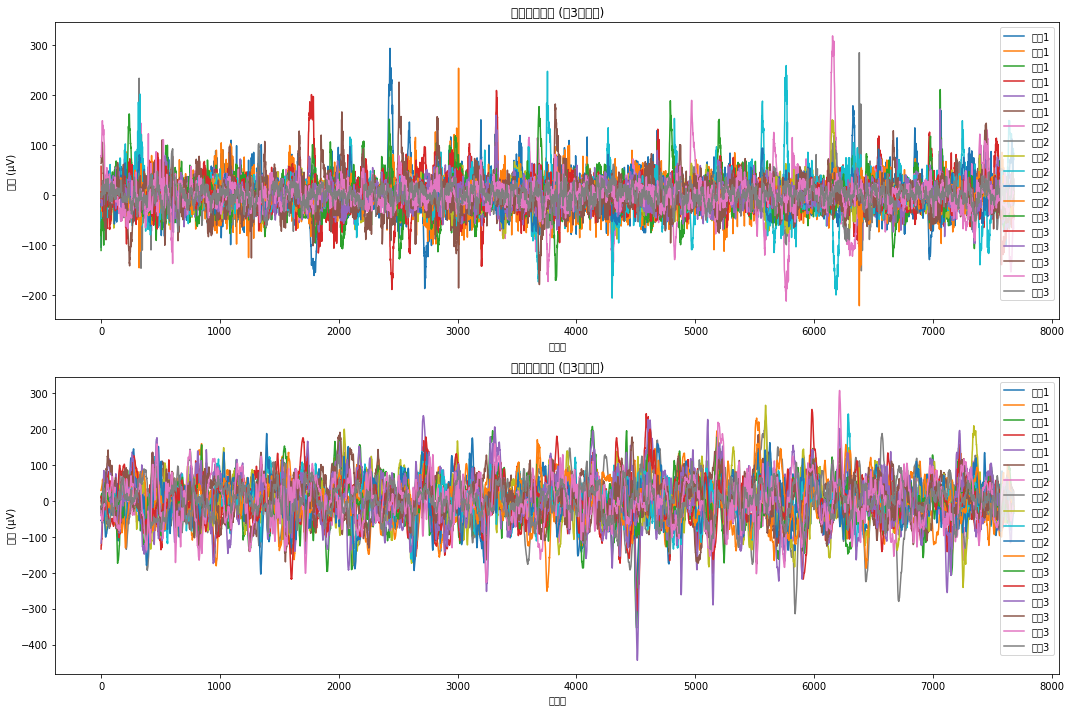

In [4]:
#!/usr/bin/env python3
"""
CHB-MIT单批次数据检查工具（硬编码版本）
"""

import numpy as np
import matplotlib.pyplot as plt

def inspect_batch_file(batch_path):
    """检查单个批次文件"""
    try:
        data = np.load(batch_path)
        windows = data['windows']
        labels = data['labels']
        
        # 基本统计
        interictal = windows[labels == 0]
        preictal = windows[labels == 1]
        
        print("\n" + "="*50)
        print(f"检查文件: {batch_path}")
        print("="*50)
        print(f"总窗口数: {len(windows)}")
        print(f"间期窗口: {len(interictal)} ({len(interictal)/len(windows):.1%})")
        print(f"前期窗口: {len(preictal)} ({len(preictal)/len(windows):.1%})")
        print(f"窗口形状: {windows.shape[1:]} (通道×采样点)")
        
        # 可视化
        plt.figure(figsize=(15, 10))
        
        # 间期样本
        plt.subplot(2, 1, 1)
        for i in range(min(3, len(interictal))):
            plt.plot(interictal[i].T, label=f'通道{i+1}')
        plt.title('间期样本示例 (前3个窗口)')
        plt.xlabel('采样点')
        plt.ylabel('幅值 (μV)')
        plt.legend()
        
        # 前期样本
        plt.subplot(2, 1, 2)
        for i in range(min(3, len(preictal))):
            plt.plot(preictal[i].T, label=f'通道{i+1}')
        plt.title('前期样本示例 (前3个窗口)')
        plt.xlabel('采样点')
        plt.ylabel('幅值 (μV)')
        plt.legend()
        
        plt.tight_layout()
       # plt.savefig(f"{batch_path.replace('.npz', '_check.png')}")
        print(f"\n检查图已保存: {batch_path.replace('.npz', '_check.png')}")
        
        return interictal, preictal
        
    except Exception as e:
        print(f"文件检查失败: {str(e)}")
        return None, None

if __name__ == "__main__":
    # 直接在这里指定文件路径（修改这一行）
    BATCH_FILE = "/root/processed_results/chb01_batch_0.npz"  # ← 修改这个路径
    
    interictal, preictal = inspect_batch_file(BATCH_FILE)
    
    if interictal is not None:
        print("\n检查完成！")
        print(f"间期数据形状: {interictal.shape}")
        print(f"前期数据形状: {preictal.shape}")

In [7]:
#!/usr/bin/env python3
"""
CHB-MIT批次数据分布检查工具（完全兼容版）
功能：批量检查所有batch文件的间期/前期分布
"""

import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob
import pandas as pd

def analyze_batch_distribution(result_dir, patient_id):
    """分析所有batch文件的分布情况"""
    batch_files = sorted(glob(os.path.join(result_dir, f"{patient_id}_batch_*.npz")))
    
    if not batch_files:
        print(f"未找到患者 {patient_id} 的batch文件")
        return None
    
    # 创建结果表格
    results = []
    
    for batch_file in batch_files:
        try:
            data = np.load(batch_file)
            labels = data['labels']
            
            n_interictal = int(np.sum(labels == 0))  # 显式转换为Python原生int
            n_preictal = int(np.sum(labels == 1))
            total = len(labels)
            
            results.append({
                'batch': os.path.basename(batch_file),
                'total': total,
                'interictal': n_interictal,
                'preictal': n_preictal,
                'ratio': n_preictal/total if total > 0 else 0.0
            })
            
            print(f"\n{batch_file}:")
            print(f"  间期: {n_interictal} ({n_interictal/total:.1%})")
            print(f"  前期: {n_preictal} ({n_preictal/total:.1%})")
            
            data.close()  # 显式关闭文件
            
        except Exception as e:
            print(f"分析 {batch_file} 失败: {str(e)}")
            continue
    
    if not results:
        print("所有batch文件分析失败")
        return None
    
    # 转换为DataFrame并保存
    df = pd.DataFrame(results)
    report_path = os.path.join(result_dir, f"{patient_id}_distribution_report.csv")
    df.to_csv(report_path, index=False)
    
    print("\n" + "="*50)
    print(f"已保存分布报告到: {report_path}")
    
    # 绘制整体分布图
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    # 批次间分布
    ax1.bar(range(len(df)), df['ratio'], color='skyblue')
    ax1.set_title('各批次前期比例')
    ax1.set_xlabel('批次编号')
    ax1.set_ylabel('前期比例')
    ax1.set_xticks(range(len(df)))
    ax1.set_xticklabels([f"B{i}" for i in range(len(df))])
    
    # 整体分布
    ax2.pie([df['interictal'].sum(), df['preictal'].sum()],
            labels=['间期', '前期'],
            autopct='%1.1f%%',
            colors=['lightgreen', 'salmon'])
    ax2.set_title('总体分布')
    
    plt.tight_layout()
    plot_path = os.path.join(result_dir, f"{patient_id}_distribution_plot.png")
    plt.savefig(plot_path)
    plt.close(fig)  # 显式关闭图形
    print(f"已保存分布图到: {plot_path}")
    
    return df

if __name__ == "__main__":
    # 配置参数
    RESULT_DIR = "/root/processed_results"
    PATIENT_ID = "chb01"
    
    print(f"开始分析患者 {PATIENT_ID} 的所有batch文件...")
    results_df = analyze_batch_distribution(RESULT_DIR, PATIENT_ID)
    
    if results_df is not None:
        print("\n汇总统计:")
        total = results_df['total'].sum()
        interictal = results_df['interictal'].sum()
        preictal = results_df['preictal'].sum()
        
        print(f"总窗口数: {total}")
        print(f"总间期窗口: {interictal} ({interictal/total:.1%})")
        print(f"总前期窗口: {preictal} ({preictal/total:.1%})")
        
        # 显示最不平衡的批次
        unbalanced_idx = results_df['ratio'].idxmax()
        unbalanced = results_df.loc[unbalanced_idx]
        print(f"\n最不平衡的批次: {unbalanced['batch']}")
        print(f"  间期: {unbalanced['interictal']}")
        print(f"  前期: {unbalanced['preictal']}")
        print(f"  比例: {unbalanced['ratio']:.1%}")

开始分析患者 chb01 的所有batch文件...

/root/processed_results/chb01_batch_0.npz:
  间期: 1011 (90.4%)
  前期: 107 (9.6%)

/root/processed_results/chb01_batch_1.npz:
  间期: 834 (85.0%)
  前期: 147 (15.0%)

/root/processed_results/chb01_batch_2.npz:
  间期: 909 (92.9%)
  前期: 69 (7.1%)

/root/processed_results/chb01_batch_3.npz:
  间期: 1200 (100.0%)
  前期: 0 (0.0%)

/root/processed_results/chb01_batch_4.npz:
  间期: 240 (100.0%)
  前期: 0 (0.0%)

已保存分布报告到: /root/processed_results/chb01_distribution_report.csv
已保存分布图到: /root/processed_results/chb01_distribution_plot.png

汇总统计:
总窗口数: 4517
总间期窗口: 4194 (92.8%)
总前期窗口: 323 (7.2%)

最不平衡的批次: chb01_batch_1.npz
  间期: 834
  前期: 147
  比例: 15.0%


In [6]:
!pip install pandas

Looking in indexes: http://mirrors.aliyun.com/pypi/simple
     |████████████████████████████████| 12.4 MB 4.4 MB/s eta 0:00:01     |█████████████████████████████▌  | 11.4 MB 4.4 MB/s eta 0:00:01
     |████████████████████████████████| 347 kB 49.2 MB/s eta 0:00:01


In [6]:
!pip uninstall pandas -y
!pip install --upgrade pandas==2.0.0 numpy matplotlib

Found existing installation: pandas 2.0.3
Uninstalling pandas-2.0.3:
  Successfully uninstalled pandas-2.0.3
Looking in indexes: http://mirrors.aliyun.com/pypi/simple
     |████████████████████████████████| 12.3 MB 16.8 MB/s eta 0:00:01
     |████████████████████████████████| 17.3 MB 9.9 MB/s eta 0:00:0101
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.7.3 requires numpy<1.23.0,>=1.16.5, but you have numpy 1.24.4 which is incompatible.


数据不平衡处理—##-------------------------------------------------------------------------------


In [1]:
#!/usr/bin/env python3
"""
癫痫预测数据平衡处理工具（跨批次随机采样版）
功能：在不同batch间进行随机采样以实现数据平衡
"""

import numpy as np
import os
from glob import glob
from sklearn.utils import resample
import random
import gc

class BatchWiseDataBalancer:
    def __init__(self, target_ratio=1.0, random_state=42, max_samples_per_class=5000):
        """
        :param target_ratio: 前期/间期目标比例
        :param random_state: 随机种子
        :param max_samples_per_class: 每类最大样本数
        """
        self.target_ratio = target_ratio
        self.random_state = random_state
        self.max_samples_per_class = max_samples_per_class
        random.seed(random_state)
        np.random.seed(random_state)

    def get_batch_stats(self, data_dir, patient_id):
        """获取每个batch的统计数据"""
        batch_files = sorted(glob(os.path.join(data_dir, f"{patient_id}_batch_*.npz")))
        
        batch_stats = []
        for batch_file in batch_files:
            with np.load(batch_file) as data:
                labels = data['labels']
                interictal_count = np.sum(labels == 0)
                preictal_count = np.sum(labels == 1)
                
                batch_stats.append({
                    'file': batch_file,
                    'interictal_count': interictal_count,
                    'preictal_count': preictal_count,
                    'total': len(labels)
                })
        
        return batch_stats

    def sample_from_batches(self, batch_stats, target_samples, class_type='interictal'):
        """
        从多个batch中随机采样指定数量的样本
        :param class_type: 'interictal' 或 'preictal'
        :param target_samples: 目标采样数量
        """
        sampled_data = []
        remaining_samples = target_samples
        
        # 计算每个batch的采样权重（基于该类样本数量）
        total_class_samples = sum(stats[f'{class_type}_count'] for stats in batch_stats)
        if total_class_samples == 0:
            return np.array([])
        
        # 按比例分配采样数量到每个batch
        batch_allocations = {}
        for stats in batch_stats:
            batch_samples = stats[f'{class_type}_count']
            if batch_samples > 0:
                allocation = max(1, int(target_samples * (batch_samples / total_class_samples)))
                batch_allocations[stats['file']] = min(allocation, batch_samples)
        
        # 调整分配以确保总数正确
        total_allocated = sum(batch_allocations.values())
        if total_allocated != target_samples:
            # 调整分配
            adjustment = target_samples - total_allocated
            for file in batch_allocations:
                if adjustment == 0:
                    break
                if adjustment > 0:
                    batch_allocations[file] += 1
                    adjustment -= 1
                else:
                    if batch_allocations[file] > 1:
                        batch_allocations[file] -= 1
                        adjustment += 1
        
        # 从每个batch中采样
        for stats in batch_stats:
            batch_file = stats['file']
            if batch_file in batch_allocations and batch_allocations[batch_file] > 0:
                with np.load(batch_file) as data:
                    labels = data['labels']
                    windows = data['windows']
                    
                    # 提取当前类别的样本
                    if class_type == 'interictal':
                        class_mask = (labels == 0)
                    else:
                        class_mask = (labels == 1)
                    
                    class_data = windows[class_mask]
                    
                    if len(class_data) > 0:
                        # 从当前batch采样
                        n_samples = min(batch_allocations[batch_file], len(class_data))
                        if n_samples > 0:
                            sampled = resample(class_data,
                                              n_samples=n_samples,
                                              replace=False,
                                              random_state=self.random_state)
                            sampled_data.append(sampled)
                            remaining_samples -= n_samples
                            
                            print(f"  从 {os.path.basename(batch_file)} 采样 {n_samples} 个{class_type}样本")
        
        if sampled_data:
            return np.concatenate(sampled_data, axis=0)
        else:
            return np.array([])

    def balance_across_batches(self, data_dir, patient_id):
        """跨批次平衡数据"""
        print(f"\n分析患者 {patient_id} 的批次数据...")
        batch_stats = self.get_batch_stats(data_dir, patient_id)
        
        # 计算总的前期样本数（决定平衡目标）
        total_preictal = sum(stats['preictal_count'] for stats in batch_stats)
        total_interictal = sum(stats['interictal_count'] for stats in batch_stats)
        
        print(f"总间期样本: {total_interictal}")
        print(f"总前期样本: {total_preictal}")
        print(f"原始比例: {total_preictal/total_interictal:.3%}")
        
        # 确定目标样本数
        if self.target_ratio == 1.0:
            # 1:1平衡，以前期样本数为基准
            target_preictal = min(total_preictal, self.max_samples_per_class)
            target_interictal = target_preictal
        else:
            # 按比例平衡
            target_preictal = min(total_preictal, self.max_samples_per_class)
            target_interictal = min(int(target_preictal / self.target_ratio), self.max_samples_per_class)
        
        print(f"\n平衡目标:")
        print(f"目标间期样本: {target_interictal}")
        print(f"目标前期样本: {target_preictal}")
        print(f"目标比例: {target_preictal/target_interictal:.3%}")
        
        # 从所有batch中采样间期数据
        print(f"\n采样间期数据...")
        interictal_sampled = self.sample_from_batches(
            batch_stats, target_interictal, 'interictal'
        )
        
        # 从所有batch中采样前期数据
        print(f"\n采样前期数据...")
        preictal_sampled = self.sample_from_batches(
            batch_stats, target_preictal, 'preictal'
        )
        
        return interictal_sampled, preictal_sampled

    def process_patient(self, data_dir, patient_id, output_dir):
        """处理单个患者"""
        os.makedirs(output_dir, exist_ok=True)
        
        # 跨批次平衡
        interictal, preictal = self.balance_across_batches(data_dir, patient_id)
        
        if len(interictal) == 0 or len(preictal) == 0:
            print("错误: 无法平衡数据（可能缺少某类样本）")
            return False
        
        print(f"\n平衡结果:")
        print(f"间期: {len(interictal)} 窗口")
        print(f"前期: {len(preictal)} 窗口")
        print(f"最终比例: {len(preictal)/len(interictal):.3%}")
        
        # 合并并打乱数据
        X = np.concatenate([interictal, preictal])
        y = np.array([0]*len(interictal) + [1]*len(preictal))
        
        # 打乱顺序
        shuffle_idx = np.random.permutation(len(X))
        X, y = X[shuffle_idx], y[shuffle_idx]
        
        # 保存结果
        output_path = os.path.join(output_dir, f"{patient_id}_balanced.npz")
        np.savez(output_path, X=X, y=y)
        print(f"\n已保存平衡数据到: {output_path}")
        
        # 清理内存
        del interictal, preictal, X, y
        gc.collect()
        
        return True

def main():
    # 配置参数
    DATA_DIR = "/root/processed_results"
    OUTPUT_DIR = "/root/balanced_data"
    PATIENT_IDS = ["chb01"]
    
    # 初始化平衡器
    balancer = BatchWiseDataBalancer(
        target_ratio=1.0,  # 1:1完全平衡
        random_state=42,
        max_samples_per_class=2000  # 限制每类最大样本数
    )
    
    # 处理所有患者
    for patient_id in PATIENT_IDS:
        print("\n" + "="*50)
        print(f"开始处理患者 {patient_id}")
        
        success = balancer.process_patient(DATA_DIR, patient_id, OUTPUT_DIR)
        if success:
            print(f"患者 {patient_id} 处理成功!")
        else:
            print(f"患者 {patient_id} 处理失败!")
    
    print("\n所有患者处理完成!")

if __name__ == "__main__":
    main()


开始处理患者 chb01

分析患者 chb01 的批次数据...
总间期样本: 4194
总前期样本: 323
原始比例: 7.701%

平衡目标:
目标间期样本: 323
目标前期样本: 323
目标比例: 100.000%

采样间期数据...
  从 chb01_batch_0.npz 采样 78 个interictal样本
  从 chb01_batch_1.npz 采样 65 个interictal样本
  从 chb01_batch_2.npz 采样 70 个interictal样本
  从 chb01_batch_3.npz 采样 92 个interictal样本
  从 chb01_batch_4.npz 采样 18 个interictal样本

采样前期数据...
  从 chb01_batch_0.npz 采样 107 个preictal样本
  从 chb01_batch_1.npz 采样 147 个preictal样本
  从 chb01_batch_2.npz 采样 69 个preictal样本

平衡结果:
间期: 323 窗口
前期: 323 窗口
最终比例: 100.000%

已保存平衡数据到: /root/balanced_data/chb01_balanced.npz
患者 chb01 处理成功!

所有患者处理完成!


In [9]:
!pip install  scikit-learn

Looking in indexes: http://mirrors.aliyun.com/pypi/simple
     |████████████████████████████████| 11.1 MB 7.9 MB/s eta 0:00:01
     |████████████████████████████████| 301 kB 58.4 MB/s eta 0:00:01


In [1]:
#!/usr/bin/env python3
"""
癫痫数据格式与分布查看工具
功能：检查平衡后的数据文件格式和分布情况
"""

import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

class DataInspector:
    def __init__(self):
        self.stats = []
    
    def inspect_npz_file(self, file_path):
        """检查单个NPZ文件的内容和分布"""
        print(f"\n{'='*60}")
        print(f"检查文件: {os.path.basename(file_path)}")
        
        try:
            # 加载数据
            data = np.load(file_path)
            
            # 显示文件内容
            print("文件包含的数组:")
            for key in data.files:
                shape = data[key].shape
                dtype = data[key].dtype
                print(f"  {key}: shape={shape}, dtype={dtype}")
            
            # 检查是否有标签数据
            if 'y' in data.files:
                labels = data['y']
                X = data['X'] if 'X' in data.files else None
                
                # 统计标签分布
                unique, counts = np.unique(labels, return_counts=True)
                label_dist = dict(zip(unique, counts))
                
                print(f"\n标签分布:")
                for label, count in label_dist.items():
                    label_name = "间期" if label == 0 else "前期"
                    print(f"  {label_name} ({label}): {count} 样本 ({count/len(labels):.1%})")
                
                # 检查数据形状
                if X is not None:
                    print(f"\n数据形状:")
                    print(f"  X shape: {X.shape}")
                    print(f"  样本数: {X.shape[0]}")
                    print(f"  特征维度: {X.shape[1:]}")
                    
                    # 检查数据范围
                    print(f"\n数据统计:")
                    print(f"  X 最小值: {X.min():.4f}")
                    print(f"  X 最大值: {X.max():.4f}")
                    print(f"  X 平均值: {X.mean():.4f}")
                    print(f"  X 标准差: {X.std():.4f}")
                
                # 保存统计信息
                self.stats.append({
                    'file': os.path.basename(file_path),
                    'total_samples': len(labels),
                    'interictal': label_dist.get(0, 0),
                    'preictal': label_dist.get(1, 0),
                    'ratio': label_dist.get(1, 0) / label_dist.get(0, 1) if label_dist.get(0, 0) > 0 else 0,
                    'balanced': abs(label_dist.get(1, 0) - label_dist.get(0, 0)) <= 1 if 0 in label_dist and 1 in label_dist else False
                })
                
            else:
                print("警告: 文件中没有找到标签数据 'y'")
                
        except Exception as e:
            print(f"错误: 无法读取文件 {file_path}: {str(e)}")
    
    def inspect_directory(self, directory_path, pattern="*.npz"):
        """检查目录中的所有NPZ文件"""
        print(f"开始检查目录: {directory_path}")
        
        # 查找所有NPZ文件
        npz_files = glob(os.path.join(directory_path, pattern))
        
        if not npz_files:
            print("未找到任何NPZ文件")
            return
        
        print(f"找到 {len(npz_files)} 个NPZ文件")
        
        # 检查每个文件
        for file_path in sorted(npz_files):
            self.inspect_npz_file(file_path)
    
    def generate_summary_report(self, output_dir=None):
        """生成汇总报告"""
        if not self.stats:
            print("没有统计数据可生成报告")
            return
        
        df = pd.DataFrame(self.stats)
        
        print(f"\n{'='*60}")
        print("数据汇总报告:")
        print('='*60)
        
        # 显示详细统计
        print("\n详细统计:")
        print(df.to_string(index=False))
        
        # 汇总统计
        total_samples = df['total_samples'].sum()
        total_interictal = df['interictal'].sum()
        total_preictal = df['preictal'].sum()
        overall_ratio = total_preictal / total_interictal if total_interictal > 0 else 0
        
        print(f"\n总体统计:")
        print(f"总文件数: {len(df)}")
        print(f"总样本数: {total_samples}")
        print(f"总间期样本: {total_interictal} ({total_interictal/total_samples:.1%})")
        print(f"总前期样本: {total_preictal} ({total_preictal/total_samples:.1%})")
        print(f"总体比例: {overall_ratio:.3f}")
        print(f"平衡文件数: {df['balanced'].sum()}/{len(df)}")
        
        # 生成可视化
        self.generate_visualizations(df, output_dir)
        
        return df
    
    def generate_visualizations(self, df, output_dir=None):
        """生成数据可视化"""
        # 设置绘图样式
        plt.style.use('seaborn-v0_8')
        sns.set_palette("Set2")
        
        # 创建图形
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('癫痫数据分布分析', fontsize=16, fontweight='bold')
        
        # 1. 各类别数量分布
        categories = ['间期', '前期']
        counts = [df['interictal'].sum(), df['preictal'].sum()]
        
        axes[0, 0].bar(categories, counts, color=['skyblue', 'lightcoral'])
        axes[0, 0].set_title('总体类别分布')
        axes[0, 0].set_ylabel('样本数量')
        for i, v in enumerate(counts):
            axes[0, 0].text(i, v + max(counts)*0.01, str(v), ha='center', fontweight='bold')
        
        # 2. 各文件样本分布
        files = df['file'].tolist()
        interictal_counts = df['interictal'].tolist()
        preictal_counts = df['preictal'].tolist()
        
        x = np.arange(len(files))
        width = 0.35
        
        axes[0, 1].bar(x - width/2, interictal_counts, width, label='间期', color='skyblue')
        axes[0, 1].bar(x + width/2, preictal_counts, width, label='前期', color='lightcoral')
        axes[0, 1].set_title('各文件类别分布')
        axes[0, 1].set_xlabel('文件')
        axes[0, 1].set_ylabel('样本数量')
        axes[0, 1].set_xticks(x)
        axes[0, 1].set_xticklabels([f[:15] + '...' if len(f) > 15 else f for f in files], rotation=45)
        axes[0, 1].legend()
        
        # 3. 比例分布
        ratios = df['ratio'].tolist()
        axes[1, 0].bar(files, ratios, color='lightgreen')
        axes[1, 0].set_title('各文件前期/间期比例')
        axes[1, 0].set_xlabel('文件')
        axes[1, 0].set_ylabel('比例')
        axes[1, 0].set_xticklabels([f[:15] + '...' if len(f) > 15 else f for f in files], rotation=45)
        axes[1, 0].axhline(y=1.0, color='red', linestyle='--', alpha=0.7, label='完美平衡线')
        axes[1, 0].legend()
        
        # 4. 样本总数分布
        total_counts = df['total_samples'].tolist()
        axes[1, 1].bar(files, total_counts, color='orange')
        axes[1, 1].set_title('各文件总样本数')
        axes[1, 1].set_xlabel('文件')
        axes[1, 1].set_ylabel('总样本数')
        axes[1, 1].set_xticklabels([f[:15] + '...' if len(f) > 15 else f for f in files], rotation=45)
        
        plt.tight_layout()
        
        if output_dir:
            os.makedirs(output_dir, exist_ok=True)
            plot_path = os.path.join(output_dir, 'data_distribution_analysis.png')
            plt.savefig(plot_path, dpi=300, bbox_inches='tight')
            print(f"\n可视化图表已保存到: {plot_path}")
        
        plt.show()
    
    def check_data_quality(self, file_path):
        """检查数据质量"""
        print(f"\n检查数据质量: {os.path.basename(file_path)}")
        
        try:
            data = np.load(file_path)
            
            if 'X' in data.files and 'y' in data.files:
                X = data['X']
                y = data['y']
                
                # 检查NaN值
                nan_count = np.isnan(X).sum()
                inf_count = np.isinf(X).sum()
                
                print(f"NaN值数量: {nan_count}")
                print(f"Inf值数量: {inf_count}")
                
                # 检查数据范围
                print(f"数据范围: [{X.min():.4f}, {X.max():.4f}]")
                print(f"数据均值: {X.mean():.4f} ± {X.std():.4f}")
                
                # 检查标签一致性
                if len(X) != len(y):
                    print(f"警告: 特征和标签数量不匹配 (X: {len(X)}, y: {len(y)})")
                else:
                    print("特征和标签数量匹配 ✓")
                
                return nan_count == 0 and inf_count == 0
            else:
                print("错误: 缺少X或y数据")
                return False
                
        except Exception as e:
            print(f"错误: {str(e)}")
            return False

def main():
    # 配置参数
    DATA_DIR = "/root/balanced_data"  # 平衡后的数据目录
    OUTPUT_DIR = "/root/data_analysis"  # 分析结果输出目录
    
    # 创建输出目录
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    # 初始化检查器
    inspector = DataInspector()
    
    print("开始检查平衡后的数据...")
    print("="*60)
    
    # 检查所有NPZ文件
    inspector.inspect_directory(DATA_DIR)
    
    # 生成汇总报告
    df_stats = inspector.generate_summary_report(OUTPUT_DIR)
    
    # 检查数据质量
    print(f"\n{'='*60}")
    print("数据质量检查:")
    print('='*60)
    
    npz_files = glob(os.path.join(DATA_DIR, "*.npz"))
    for file_path in sorted(npz_files):
        is_clean = inspector.check_data_quality(file_path)
        status = "通过" if is_clean else "失败"
        print(f"数据质量: {status}")
    
    # 保存统计报告到CSV
    if df_stats is not None:
        csv_path = os.path.join(OUTPUT_DIR, 'data_statistics.csv')
        df_stats.to_csv(csv_path, index=False, encoding='utf-8-sig')
        print(f"\n详细统计已保存到: {csv_path}")
    
    print(f"\n检查完成! 结果保存在: {OUTPUT_DIR}")

if __name__ == "__main__":
    main()

开始检查平衡后的数据...
开始检查目录: /root/balanced_data
找到 1 个NPZ文件

检查文件: chb01_balanced.npz
文件包含的数组:
  X: shape=(646, 6, 7680), dtype=float64
  y: shape=(646,), dtype=int64

标签分布:
  间期 (0): 323 样本 (50.0%)
  前期 (1): 323 样本 (50.0%)

数据形状:
  X shape: (646, 6, 7680)
  样本数: 646
  特征维度: (6, 7680)

数据统计:
  X 最小值: -1702.7678
  X 最大值: 1518.7848
  X 平均值: 0.1955
  X 标准差: 38.5820

数据汇总报告:

详细统计:
              file  total_samples  interictal  preictal  ratio  balanced
chb01_balanced.npz            646         323       323    1.0      True

总体统计:
总文件数: 1
总样本数: 646
总间期样本: 323 (50.0%)
总前期样本: 323 (50.0%)
总体比例: 1.000
平衡文件数: 1/1


OSError: 'seaborn-v0_8' not found in the style library and input is not a valid URL or path; see `style.available` for list of available styles

In [3]:
!pip install seaborn


Looking in indexes: http://mirrors.aliyun.com/pypi/simple
     |████████████████████████████████| 294 kB 2.1 MB/s eta 0:00:01


In [2]:
###9.30数据批处理
#!/usr/bin/env python3
"""
癫痫预测数据平衡处理工具（跨批次随机采样版）
功能：在不同batch间进行随机采样以实现数据平衡
"""

import numpy as np
import os
from glob import glob
from sklearn.utils import resample
import random
import gc

class BatchWiseDataBalancer:
    def __init__(self, target_ratio=1.0, random_state=42, max_samples_per_class=5000):
        """
        :param target_ratio: 前期/间期目标比例
        :param random_state: 随机种子
        :param max_samples_per_class: 每类最大样本数
        """
        self.target_ratio = target_ratio
        self.random_state = random_state
        self.max_samples_per_class = max_samples_per_class
        random.seed(random_state)
        np.random.seed(random_state)

    def get_batch_stats(self, data_dir, patient_id):
        """获取每个batch的统计数据"""
        batch_files = sorted(glob(os.path.join(data_dir, f"{patient_id}_batch_*.npz")))
        
        batch_stats = []
        for batch_file in batch_files:
            with np.load(batch_file) as data:
                labels = data['labels']
                interictal_count = np.sum(labels == 0)
                preictal_count = np.sum(labels == 1)
                
                batch_stats.append({
                    'file': batch_file,
                    'interictal_count': interictal_count,
                    'preictal_count': preictal_count,
                    'total': len(labels)
                })
        
        return batch_stats

    def sample_from_batches(self, batch_stats, target_samples, class_type='interictal'):
        """
        从多个batch中随机采样指定数量的样本
        :param class_type: 'interictal' 或 'preictal'
        :param target_samples: 目标采样数量
        """
        sampled_data = []
        remaining_samples = target_samples
        
        # 计算每个batch的采样权重（基于该类样本数量）
        total_class_samples = sum(stats[f'{class_type}_count'] for stats in batch_stats)
        if total_class_samples == 0:
            return np.array([])
        
        # 按比例分配采样数量到每个batch
        batch_allocations = {}
        for stats in batch_stats:
            batch_samples = stats[f'{class_type}_count']
            if batch_samples > 0:
                allocation = max(1, int(target_samples * (batch_samples / total_class_samples)))
                batch_allocations[stats['file']] = min(allocation, batch_samples)
        
        # 调整分配以确保总数正确
        total_allocated = sum(batch_allocations.values())
        if total_allocated != target_samples:
            # 调整分配
            adjustment = target_samples - total_allocated
            for file in batch_allocations:
                if adjustment == 0:
                    break
                if adjustment > 0:
                    batch_allocations[file] += 1
                    adjustment -= 1
                else:
                    if batch_allocations[file] > 1:
                        batch_allocations[file] -= 1
                        adjustment += 1
        
        # 从每个batch中采样
        for stats in batch_stats:
            batch_file = stats['file']
            if batch_file in batch_allocations and batch_allocations[batch_file] > 0:
                with np.load(batch_file) as data:
                    labels = data['labels']
                    windows = data['windows']
                    
                    # 提取当前类别的样本
                    if class_type == 'interictal':
                        class_mask = (labels == 0)
                    else:
                        class_mask = (labels == 1)
                    
                    class_data = windows[class_mask]
                    
                    if len(class_data) > 0:
                        # 从当前batch采样
                        n_samples = min(batch_allocations[batch_file], len(class_data))
                        if n_samples > 0:
                            sampled = resample(class_data,
                                              n_samples=n_samples,
                                              replace=False,
                                              random_state=self.random_state)
                            sampled_data.append(sampled)
                            remaining_samples -= n_samples
                            
                            print(f"  从 {os.path.basename(batch_file)} 采样 {n_samples} 个{class_type}样本")
        
        if sampled_data:
            return np.concatenate(sampled_data, axis=0)
        else:
            return np.array([])

    def balance_across_batches(self, data_dir, patient_id):
        """跨批次平衡数据"""
        print(f"\n分析患者 {patient_id} 的批次数据...")
        batch_stats = self.get_batch_stats(data_dir, patient_id)
        
        # 计算总的前期样本数（决定平衡目标）
        total_preictal = sum(stats['preictal_count'] for stats in batch_stats)
        total_interictal = sum(stats['interictal_count'] for stats in batch_stats)
        
        print(f"总间期样本: {total_interictal}")
        print(f"总前期样本: {total_preictal}")
        print(f"原始比例: {total_preictal/total_interictal:.3%}")
        
        # 确定目标样本数
        if self.target_ratio == 1.0:
            # 1:1平衡，以前期样本数为基准
            target_preictal = min(total_preictal, self.max_samples_per_class)
            target_interictal = target_preictal
        else:
            # 按比例平衡
            target_preictal = min(total_preictal, self.max_samples_per_class)
            target_interictal = min(int(target_preictal / self.target_ratio), self.max_samples_per_class)
        
        print(f"\n平衡目标:")
        print(f"目标间期样本: {target_interictal}")
        print(f"目标前期样本: {target_preictal}")
        print(f"目标比例: {target_preictal/target_interictal:.3%}")
        
        # 从所有batch中采样间期数据
        print(f"\n采样间期数据...")
        interictal_sampled = self.sample_from_batches(
            batch_stats, target_interictal, 'interictal'
        )
        
        # 从所有batch中采样前期数据
        print(f"\n采样前期数据...")
        preictal_sampled = self.sample_from_batches(
            batch_stats, target_preictal, 'preictal'
        )
        
        return interictal_sampled, preictal_sampled

    def process_patient(self, data_dir, patient_id, output_dir):
        """处理单个患者"""
        os.makedirs(output_dir, exist_ok=True)
        
        # 跨批次平衡
        interictal, preictal = self.balance_across_batches(data_dir, patient_id)
        
        if len(interictal) == 0 or len(preictal) == 0:
            print("错误: 无法平衡数据（可能缺少某类样本）")
            return False
        
        print(f"\n平衡结果:")
        print(f"间期: {len(interictal)} 窗口")
        print(f"前期: {len(preictal)} 窗口")
        print(f"最终比例: {len(preictal)/len(interictal):.3%}")
        
        # 合并并打乱数据
        X = np.concatenate([interictal, preictal])
        y = np.array([0]*len(interictal) + [1]*len(preictal))
        
        # 打乱顺序
        shuffle_idx = np.random.permutation(len(X))
        X, y = X[shuffle_idx], y[shuffle_idx]
        
        # 保存结果
        output_path = os.path.join(output_dir, f"{patient_id}_balanced.npz")
        np.savez(output_path, X=X, y=y)
        print(f"\n已保存平衡数据到: {output_path}")
        
        # 清理内存
        del interictal, preictal, X, y
        gc.collect()
        
        return True

def main():
    # 配置参数
    DATA_DIR = "/root/processed_results"
    OUTPUT_DIR = "/root/balanced_data"
    PATIENT_IDS = ["chb02"]
    
    # 初始化平衡器
    balancer = BatchWiseDataBalancer(
        target_ratio=1.0,  # 1:1完全平衡
        random_state=42,
        max_samples_per_class=2000  # 限制每类最大样本数
    )
    
    # 处理所有患者
    for patient_id in PATIENT_IDS:
        print("\n" + "="*50)
        print(f"开始处理患者 {patient_id}")
        
        success = balancer.process_patient(DATA_DIR, patient_id, OUTPUT_DIR)
        if success:
            print(f"患者 {patient_id} 处理成功!")
        else:
            print(f"患者 {patient_id} 处理失败!")
    
    print("\n所有患者处理完成!")

if __name__ == "__main__":
    main()


开始处理患者 chb02

分析患者 chb02 的批次数据...
总间期样本: 4053
总前期样本: 122
原始比例: 3.010%

平衡目标:
目标间期样本: 122
目标前期样本: 122
目标比例: 100.000%

采样间期数据...
  从 chb02_batch_0.npz 采样 37 个interictal样本
  从 chb02_batch_1.npz 采样 28 个interictal样本
  从 chb02_batch_2.npz 采样 36 个interictal样本
  从 chb02_batch_3.npz 采样 21 个interictal样本

采样前期数据...
  从 chb02_batch_1.npz 采样 122 个preictal样本

平衡结果:
间期: 122 窗口
前期: 122 窗口
最终比例: 100.000%

已保存平衡数据到: /root/balanced_data/chb02_balanced.npz
患者 chb02 处理成功!

所有患者处理完成!
